🔹 DATA_DIR_IN:  C:\Users\send2\OneDrive\Desktop\Testing\Test\Data
🔹 DATA_DIR_OUT: C:\Users\send2\OneDrive\Desktop\Testing\Test\Results
[INFO] Saved raw means → C:\Users\send2\OneDrive\Desktop\Testing\Test\Results\experiment_column_means.csv


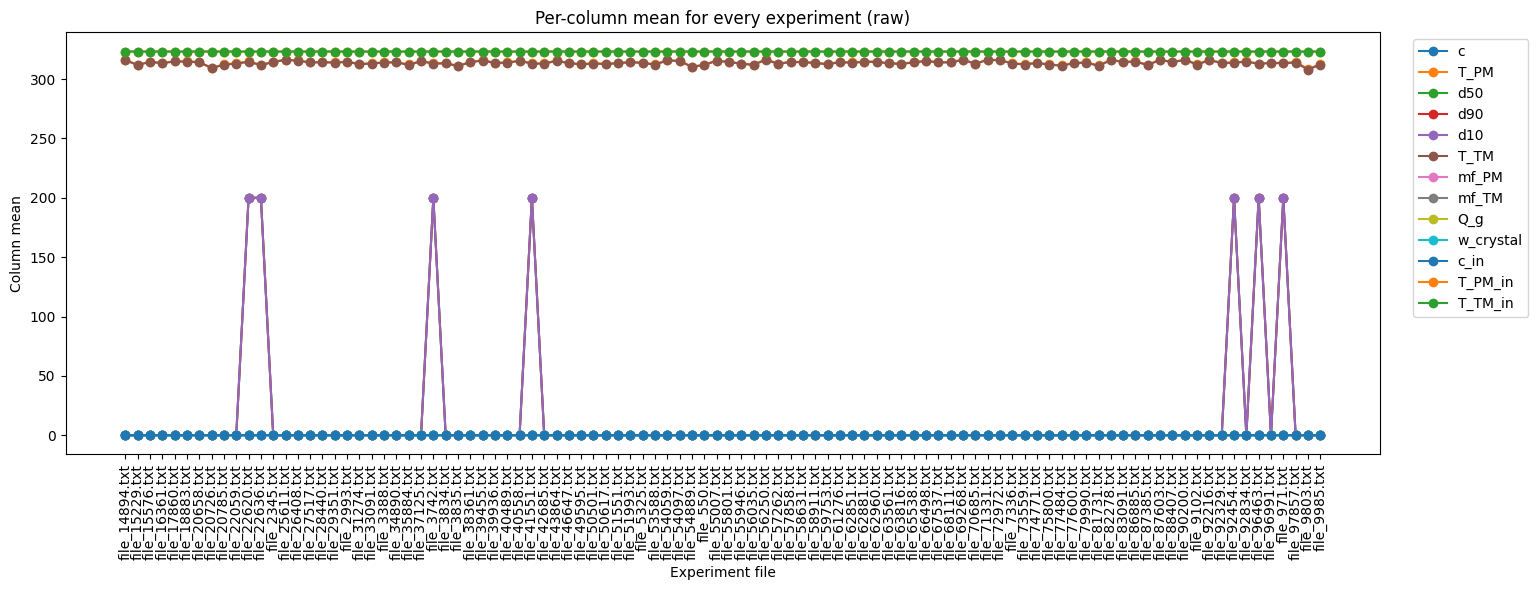

[INFO] Filtered 7 outlier run(s) → C:\Users\send2\OneDrive\Desktop\Testing\Test\Results\removed_experiments.csv
[INFO] Clean means table → C:\Users\send2\OneDrive\Desktop\Testing\Test\Results\experiment_column_means_filtered.csv


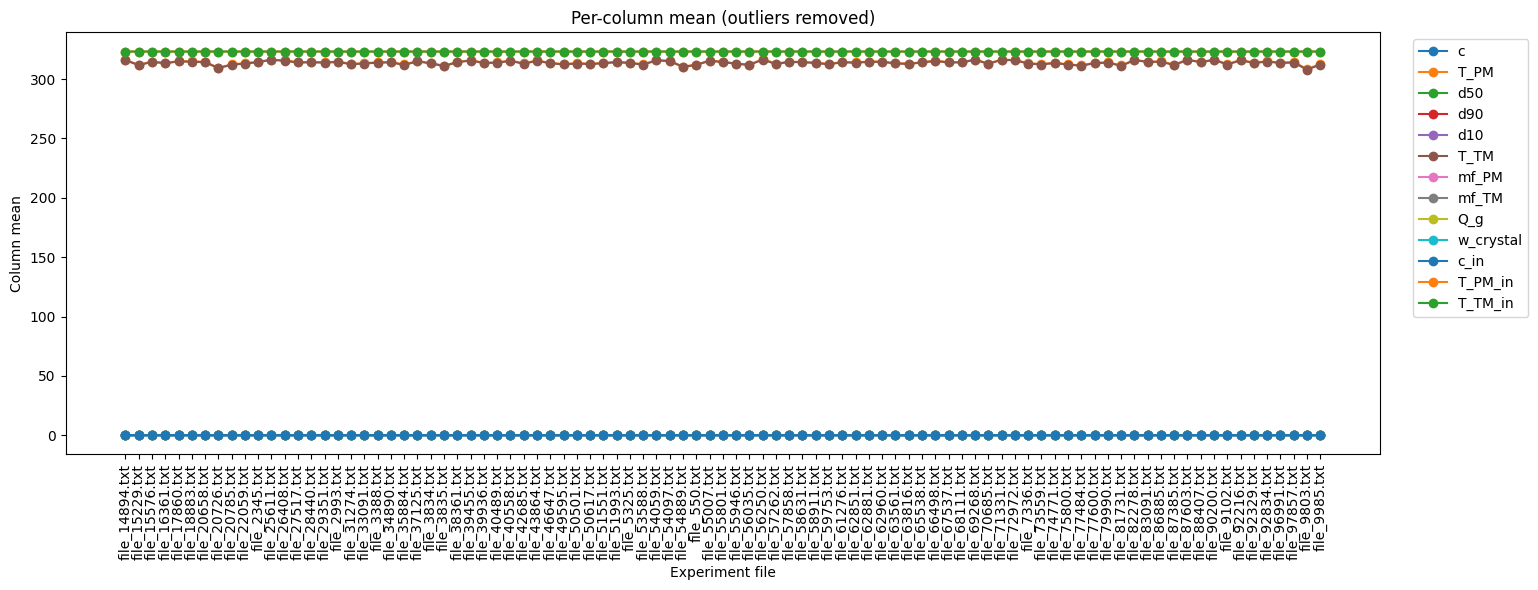

C:\Users\send2\AppData\Local\Temp\ipykernel_828\3959572042.py:165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kept_df["cluster"] = cluster_labels


[INFO] K-means finished → k = 2 (silhouette = 0.302)
[INFO] Saving KMeans model → C:\Users\send2\OneDrive\Desktop\Testing\Test\Results\kmeans.pkl
[INFO] Assignment table → C:\Users\send2\OneDrive\Desktop\Testing\Test\Results\cluster_assignments.csv


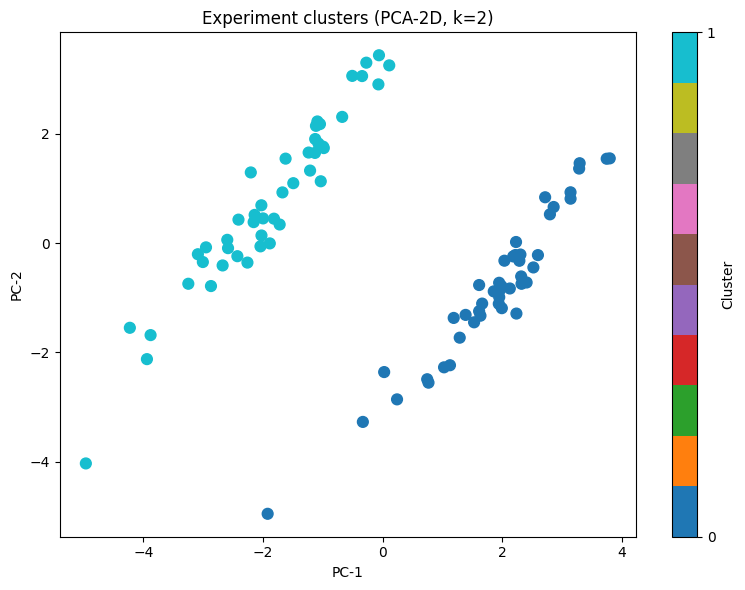

[INFO] PCA image saved → C:\Users\send2\OneDrive\Desktop\Testing\Test\Results\pca_clusters.png


In [26]:
from __future__ import annotations

import os
import sys
import random
import warnings
import glob

import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import (silhouette_score, mean_squared_error, mean_absolute_error, r2_score,)

# ─── Global Settings (portable) ────────────────────────────────────────────────
import os
from pathlib import Path

# 1) Determine repository root (where this notebook lives)
BASE_DIR = Path().resolve()

# 2) Default input and output directories (relative to repo)
DEFAULT_IN  = BASE_DIR / "Data"
DEFAULT_OUT = BASE_DIR / "Results"

# 3) Allow environment overrides
DATA_DIR_IN  = Path(os.getenv("MLME_DATA_IN",  DEFAULT_IN))
DATA_DIR_OUT = Path(os.getenv("MLME_DATA_OUT", DEFAULT_OUT))

# 4) Create output directory if it doesn't exist
DATA_DIR_OUT.mkdir(parents=True, exist_ok=True)

# 5) Report settings
print(f"🔹 DATA_DIR_IN:  {DATA_DIR_IN}")
print(f"🔹 DATA_DIR_OUT: {DATA_DIR_OUT}")
# ────────────────────────────────────────────────────────────────────────────────
# e.g. listing files
txt_files = list(DATA_DIR_IN.glob("*.txt"))

# reading and writing
import pandas as pd
df = pd.read_csv(txt_files[0], sep="\t")
df.to_csv(DATA_DIR_OUT / "summary.csv", index=False)

# ═════════════════════════════════════════════════════════════
# 1. GATHER EXPERIMENT FILES
# ═════════════════════════════════════════════════════════════
txt_files = [
    os.path.join(root, fn)
    for root, _, files in os.walk(DATA_DIR_IN)
    for fn in files
    if fn.lower().endswith(".txt")
]
if not txt_files:
    sys.exit(f"[ERROR] No .txt files found under {DATA_DIR_IN}")

# ═════════════════════════════════════════════════════════════
# 2. BUILD TABLE OF COLUMN MEANS
# ═════════════════════════════════════════════════════════════
rows: list[pd.Series] = []
for fp in txt_files:
    try:
        df = pd.read_csv(fp, sep="\t")
    except Exception:
        df = pd.read_csv(fp, delim_whitespace=True)

    num_df = df.select_dtypes(include=[np.number])
    if num_df.empty:
        warnings.warn(f"{os.path.basename(fp)} → skipped (no numeric cols)")
        continue

    s = num_df.mean()
    s.name = os.path.basename(fp)          # row label = file name
    rows.append(s)

means_df = pd.DataFrame(rows).sort_index()
raw_csv = os.path.join(DATA_DIR_OUT, "experiment_column_means.csv")
means_df.to_csv(raw_csv, index_label="experiment")
print(f"[INFO] Saved raw means → {raw_csv}")

# ═════════════════════════════════════════════════════════════
# 3. RAW PLOT
# ═════════════════════════════════════════════════════════════
plt.figure(figsize=(14, 6))
for col in means_df.columns:
    plt.plot(means_df.index, means_df[col], marker="o", label=col)
plt.title("Per-column mean for every experiment (raw)")
plt.xlabel("Experiment file"); plt.ylabel("Column mean")
plt.xticks(rotation=90); plt.tight_layout()
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.show()

# ═════════════════════════════════════════════════════════════
# 4. OUTLIER FILTER (d10 / d50 / d90, 1.5×IQR)
# ═════════════════════════════════════════════════════════════
def iqr_mask(series: pd.Series) -> pd.Series:
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    return (series < q1 - 1.5 * iqr) | (series > q3 + 1.5 * iqr)

cols_check = [c for c in ("d10", "d50", "d90") if c in means_df.columns]
mask_outlier = pd.Series(False, index=means_df.index)
for c in cols_check:
    mask_outlier |= iqr_mask(means_df[c])

removed_df = means_df[mask_outlier]
kept_df    = means_df[~mask_outlier]

removed_csv  = os.path.join(DATA_DIR_OUT, "removed_experiments.csv")
kept_csv     = os.path.join(DATA_DIR_OUT, "experiment_column_means_filtered.csv")
removed_df.index.to_series().to_csv(removed_csv, index=False, header=False)
kept_df.to_csv(kept_csv, index_label="experiment")
print(f"[INFO] Filtered {len(removed_df)} outlier run(s) → {removed_csv}")
print(f"[INFO] Clean means table → {kept_csv}")

# ═════════════════════════════════════════════════════════════
# 5. FILTERED PLOT
# ═════════════════════════════════════════════════════════════
plt.figure(figsize=(14, 6))
for col in kept_df.columns:
    plt.plot(kept_df.index, kept_df[col], marker="o", label=col)
plt.title("Per-column mean (outliers removed)")
plt.xlabel("Experiment file"); plt.ylabel("Column mean")
plt.xticks(rotation=90); plt.tight_layout()
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.show()

# ═════════════════════════════════════════════════════════════
# 6. K-MEANS CLUSTERING ON CLEAN DATA
# ═════════════════════════════════════════════════════════════
if len(kept_df) < 3:
    sys.exit("[ERROR] Too few clean experiments to cluster.")

# fill NaNs – (rare: cols missing in some files)
X = kept_df.fillna(kept_df.mean()).values
X_scaled = StandardScaler().fit_transform(X)

# choose best k by silhouette, 2 ≤ k ≤ 10  or ≤ N-1
best_k, best_score = None, -1
for k in range(2, min(10, len(kept_df))):
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(X_scaled)
    try:
        score = silhouette_score(X_scaled, labels)
    except ValueError:        # happens if all pts in 1 cluster
        continue
    if score > best_score:
        best_k, best_score = k, score

if best_k is None:           # fallback
    best_k = 2
    best_score = float("nan")

kmeans = KMeans(n_clusters=best_k, n_init=10, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)
kept_df["cluster"] = cluster_labels
print(f"[INFO] K-means finished → k = {best_k} (silhouette = {best_score:.3f})")
# save the model
kmeans_path = os.path.join(DATA_DIR_OUT, "kmeans.pkl")
print(f"[INFO] Saving KMeans model → {kmeans_path}")
joblib.dump(kmeans, kmeans_path)
# ═════════════════════════════════════════════════════════════
# 7. SAVE CLUSTER LISTS
# ═════════════════════════════════════════════════════════════
assign_csv = os.path.join(DATA_DIR_OUT, "cluster_assignments.csv")
kept_df["cluster"].to_csv(assign_csv, header=["cluster"])
print(f"[INFO] Assignment table → {assign_csv}")

for cl in sorted(kept_df["cluster"].unique()):
    cl_csv = os.path.join(DATA_DIR_OUT, f"cluster_{cl}.csv")
    kept_df[kept_df["cluster"] == cl].index.to_series().to_csv(
        cl_csv, index=False, header=False
    )

# ═════════════════════════════════════════════════════════════
# 8. 2-D PCA VISUALISATION
# ═════════════════════════════════════════════════════════════
pca = PCA(n_components=2, random_state=42)
XY = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(XY[:, 0], XY[:, 1], c=cluster_labels,
                      cmap="tab10", s=60)
plt.title(f"Experiment clusters (PCA-2D, k={best_k})")
plt.xlabel("PC-1"); plt.ylabel("PC-2")
plt.colorbar(scatter, ticks=range(best_k), label="Cluster")
plt.tight_layout()
pca_png = os.path.join(DATA_DIR_OUT, "pca_clusters.png")
plt.savefig(pca_png, dpi=150)
plt.show()
print(f"[INFO] PCA image saved → {pca_png}")   
# ═════════════════════════════════════════════════════════════

In [27]:

# ══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════
# 9.  SPLIT EVERY CLUSTER LIST → train / val / calib / test(60 % | 20 % | 10 % | 10 % of whole-files, not rows)
# ══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════
_SEED   = 42
_SPLITS = ("train", "val", "calib", "test")
_RATIOS = (0.6, 0.2, 0.1, 0.1)         # must sum to 1.0
rng     = np.random.default_rng(_SEED)

def split_files(filelist, ratios=_RATIOS):
    """Return {split_name: list_of_files} according to ratios."""
    filelist = list(filelist)
    rng.shuffle(filelist)
    n = len(filelist)

    ntrain = int(ratios[0]*n)
    nval   = int(ratios[1]*n)
    ncalib = int(ratios[2]*n)
    return {
        "train":  filelist[:ntrain],
        "val":    filelist[ntrain:ntrain+nval],
        "calib":  filelist[ntrain+nval:ntrain+nval+ncalib],
        "test":   filelist[ntrain+nval+ncalib:],
    }

# loop again over every cluster list we just wrote
for cl_csv in glob.glob(os.path.join(DATA_DIR_OUT, "cluster_*.csv")):
    cid   = os.path.splitext(os.path.basename(cl_csv))[0].split("_")[-1]
    files = pd.read_csv(cl_csv, header=None)[0].tolist()

    if len(files) < 10:
        print(f"[WARN] cluster {cid} has only {len(files)} file(s) – skipped split")
        continue

    splits = split_files(files)

    for split_name, paths in splits.items():
        out_csv = os.path.join(DATA_DIR_OUT, f"cluster_{cid}_{split_name}.csv")
        pd.Series(paths).to_csv(out_csv, index=False, header=False)
        print(f"[INFO] cluster {cid}: wrote {split_name} list → {out_csv}")


[INFO] cluster 0: wrote train list → C:\Users\send2\OneDrive\Desktop\Testing\Test\Results\cluster_0_train.csv
[INFO] cluster 0: wrote val list → C:\Users\send2\OneDrive\Desktop\Testing\Test\Results\cluster_0_val.csv
[INFO] cluster 0: wrote calib list → C:\Users\send2\OneDrive\Desktop\Testing\Test\Results\cluster_0_calib.csv
[INFO] cluster 0: wrote test list → C:\Users\send2\OneDrive\Desktop\Testing\Test\Results\cluster_0_test.csv
[WARN] cluster calib has only 4 file(s) – skipped split
[WARN] cluster test has only 5 file(s) – skipped split
[INFO] cluster train: wrote train list → C:\Users\send2\OneDrive\Desktop\Testing\Test\Results\cluster_train_train.csv
[INFO] cluster train: wrote val list → C:\Users\send2\OneDrive\Desktop\Testing\Test\Results\cluster_train_val.csv
[INFO] cluster train: wrote calib list → C:\Users\send2\OneDrive\Desktop\Testing\Test\Results\cluster_train_calib.csv
[INFO] cluster train: wrote test list → C:\Users\send2\OneDrive\Desktop\Testing\Test\Results\cluster_trai


>>> CLUSTER 0


C:\Users\send2\AppData\Local\Temp\ipykernel_828\2500204193.py:68: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filtered[col] = df_filtered[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
C:\Users\send2\AppData\Local\Temp\ipykernel_828\2500204193.py:68: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filtered[col] = df_filtered[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
C:\Users\send2\AppData\Local\Temp\ipykernel_828\2500204193.py:68: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filtered[col] = df_filtered[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
C:\Users\send2\AppData\Local\Temp\ipykernel_828\2500204193.py:68

  train: 26892 samples


C:\Users\send2\AppData\Local\Temp\ipykernel_828\2500204193.py:68: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filtered[col] = df_filtered[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
C:\Users\send2\AppData\Local\Temp\ipykernel_828\2500204193.py:68: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filtered[col] = df_filtered[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
C:\Users\send2\AppData\Local\Temp\ipykernel_828\2500204193.py:68: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filtered[col] = df_filtered[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
C:\Users\send2\AppData\Local\Temp\ipykernel_828\2500204193.py:68

  val: 8964 samples


C:\Users\send2\AppData\Local\Temp\ipykernel_828\2500204193.py:68: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filtered[col] = df_filtered[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
C:\Users\send2\AppData\Local\Temp\ipykernel_828\2500204193.py:68: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filtered[col] = df_filtered[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
C:\Users\send2\AppData\Local\Temp\ipykernel_828\2500204193.py:68: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filtered[col] = df_filtered[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
C:\Users\send2\AppData\Local\Temp\ipykernel_828\2500204193.py:68

  calib: 3984 samples


C:\Users\send2\AppData\Local\Temp\ipykernel_828\2500204193.py:68: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filtered[col] = df_filtered[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
C:\Users\send2\AppData\Local\Temp\ipykernel_828\2500204193.py:68: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filtered[col] = df_filtered[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
C:\Users\send2\AppData\Local\Temp\ipykernel_828\2500204193.py:68: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filtered[col] = df_filtered[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
C:\Users\send2\AppData\Local\Temp\ipykernel_828\2500204193.py:68

  test: 4980 samples
  epoch 25/150  val MSE=2.928e-02
  epoch 50/150  val MSE=2.796e-02
  epoch 75/150  val MSE=2.755e-02
  epoch 100/150  val MSE=2.870e-02
  epoch 125/150  val MSE=2.940e-02
  epoch 150/150  val MSE=2.624e-02


,MSE,MAE,R2
State,,,
c,1.450808e-07,1.948541e-04,0.992538
T_PM,8.331820e-02,1.292094e-01,0.994931
d10,1.278691e-11,2.106767e-06,0.992144
d50,1.508205e-11,2.140039e-06,0.990059
d90,1.196045e-11,2.256239e-06,0.992616
T_TM,6.731212e-02,1.195200e-01,0.996067


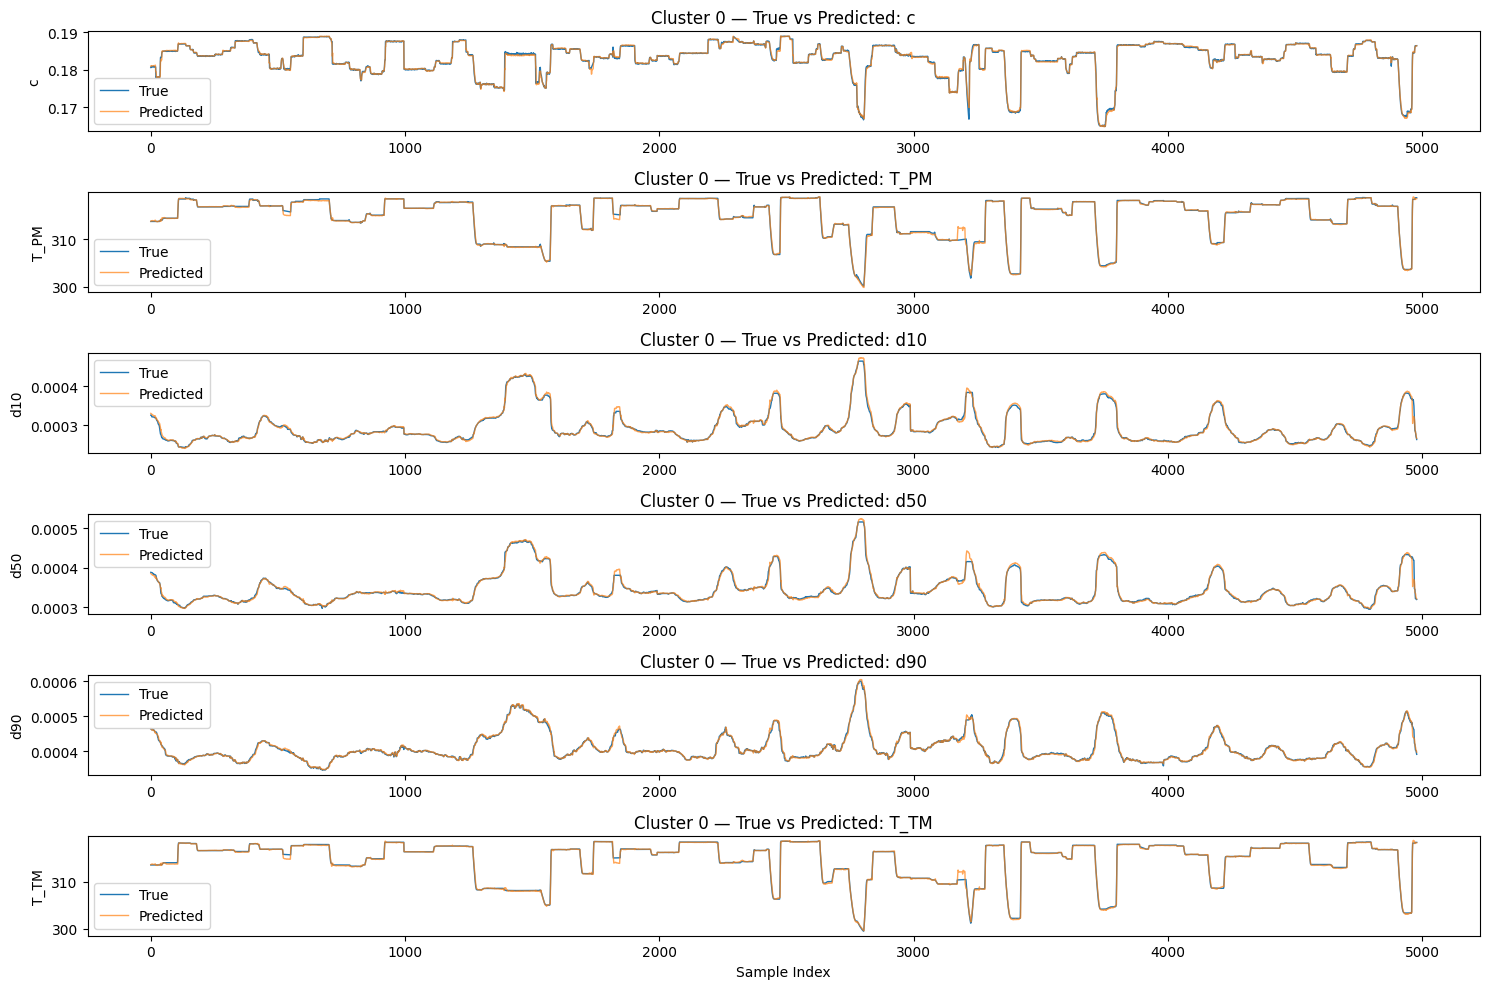

[✓] Saved narx_cluster_0.pt

>>> CLUSTER 1


C:\Users\send2\AppData\Local\Temp\ipykernel_828\2500204193.py:68: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filtered[col] = df_filtered[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
C:\Users\send2\AppData\Local\Temp\ipykernel_828\2500204193.py:68: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filtered[col] = df_filtered[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
C:\Users\send2\AppData\Local\Temp\ipykernel_828\2500204193.py:68: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filtered[col] = df_filtered[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
C:\Users\send2\AppData\Local\Temp\ipykernel_828\2500204193.py:68

  train: 26892 samples


C:\Users\send2\AppData\Local\Temp\ipykernel_828\2500204193.py:68: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filtered[col] = df_filtered[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
C:\Users\send2\AppData\Local\Temp\ipykernel_828\2500204193.py:68: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filtered[col] = df_filtered[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
C:\Users\send2\AppData\Local\Temp\ipykernel_828\2500204193.py:68: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filtered[col] = df_filtered[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
C:\Users\send2\AppData\Local\Temp\ipykernel_828\2500204193.py:68

  val: 8964 samples


C:\Users\send2\AppData\Local\Temp\ipykernel_828\2500204193.py:68: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filtered[col] = df_filtered[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
C:\Users\send2\AppData\Local\Temp\ipykernel_828\2500204193.py:68: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filtered[col] = df_filtered[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
C:\Users\send2\AppData\Local\Temp\ipykernel_828\2500204193.py:68: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filtered[col] = df_filtered[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
C:\Users\send2\AppData\Local\Temp\ipykernel_828\2500204193.py:68

  calib: 3984 samples


C:\Users\send2\AppData\Local\Temp\ipykernel_828\2500204193.py:68: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filtered[col] = df_filtered[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
C:\Users\send2\AppData\Local\Temp\ipykernel_828\2500204193.py:68: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filtered[col] = df_filtered[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
C:\Users\send2\AppData\Local\Temp\ipykernel_828\2500204193.py:68: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filtered[col] = df_filtered[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
C:\Users\send2\AppData\Local\Temp\ipykernel_828\2500204193.py:68

  test: 5976 samples
  epoch 25/150  val MSE=1.528e-02
  epoch 50/150  val MSE=1.341e-02
  epoch 75/150  val MSE=1.348e-02
  epoch 100/150  val MSE=1.492e-02
  epoch 125/150  val MSE=1.464e-02
  epoch 150/150  val MSE=1.413e-02


,MSE,MAE,R2
State,,,
c,1.266283e-07,1.521210e-04,0.993945
T_PM,1.319378e-01,1.701590e-01,0.994956
d10,1.658723e-11,2.385372e-06,0.993568
d50,1.199856e-11,2.117195e-06,0.995218
d90,1.601334e-11,2.638260e-06,0.993931
T_TM,1.136393e-01,1.418502e-01,0.995828


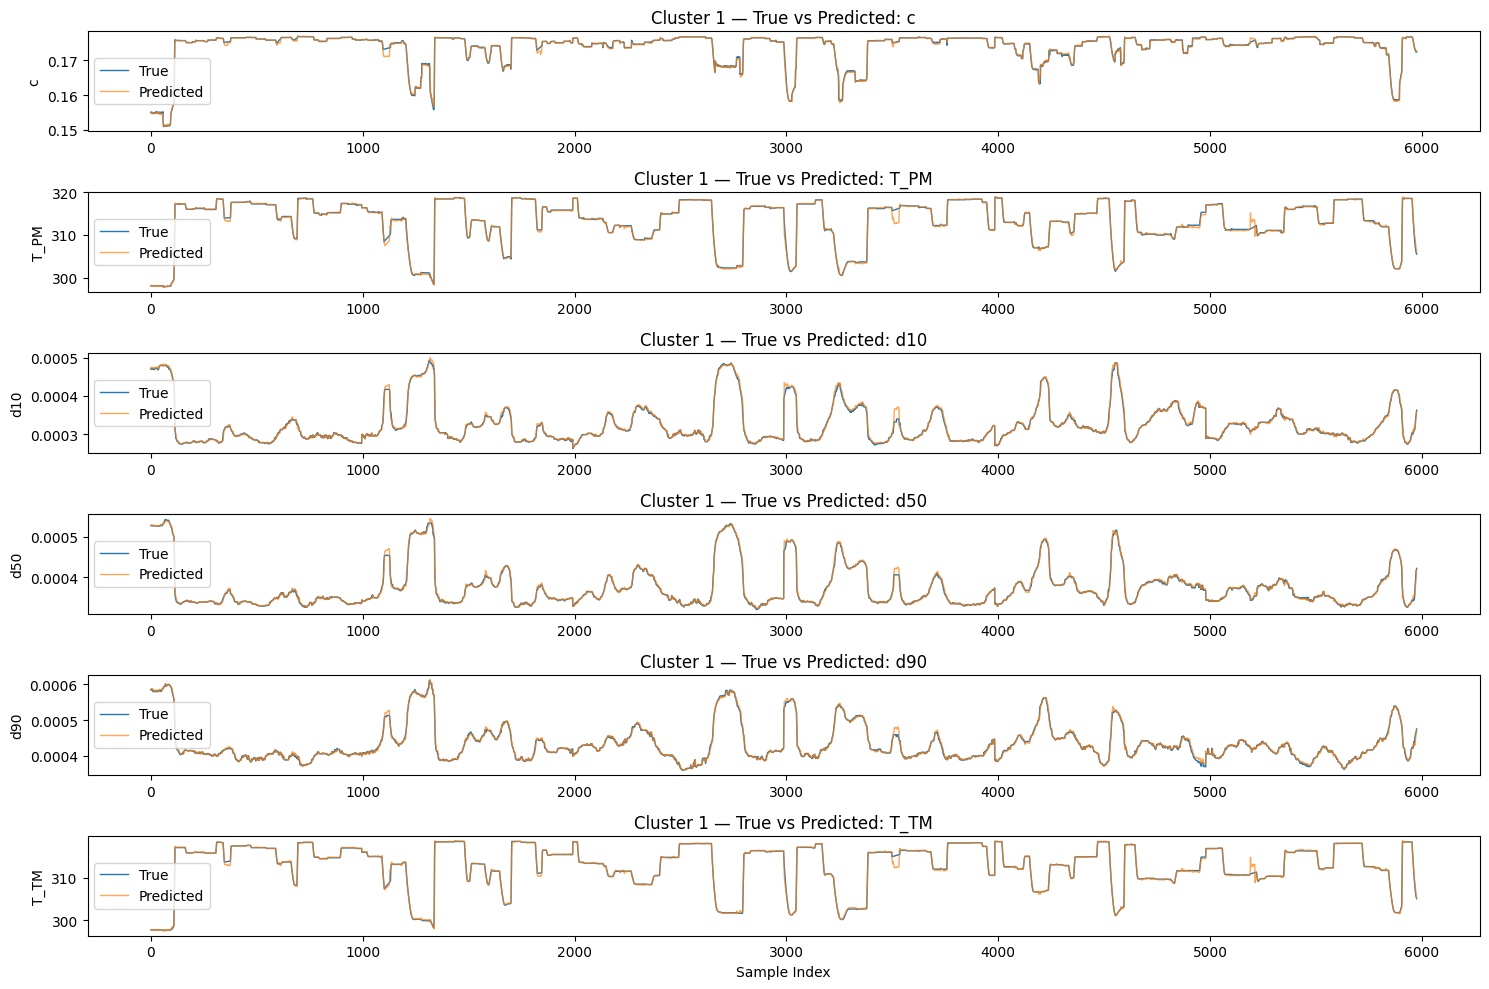

[✓] Saved narx_cluster_1.pt


In [28]:

# ══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════
# 10.  ANN MODEL TRAINING Evauation and Visualization
# ══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════

import os
import glob
import warnings
import random
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# ── ANN PARAMETERS ───────────────────────────────────────────────────────────────
TARGET_COLS   = ["c", "T_PM", "d10", "d50", "d90", "T_TM"]
INPUT_COLS    = ["mf_PM","mf_TM","Q_g","w_crystal","c_in","T_PM_in","T_TM_in"]
NA, NB        = 1, 3                 # optimized lags
H1, H2, H3    = 64,32,64          # hidden layer sizes
DROPOUT       = 0.00458497434616801  # dropout rate
EPOCHS        = 150
BATCH_SIZE    = 128
LR            = 0.00034001634751490005
WEIGHT_DECAY  = 1.0551546494170664e-05  # L2 penalty
SEED          = 42
DEVICE        = "cuda" if torch.cuda.is_available() else "cpu"

# reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# ── HELPERS ───────────────────────────────────────────────────────────────────────
def read_txt(fp):
    try:
        return pd.read_csv(fp, sep="\t")
    except:
        return pd.read_csv(fp, delim_whitespace=True)

def build_narx(df):
    maxlag = max(NA, NB)
    Xs, Ys = [], []
    for t in range(maxlag, len(df)-1):
        py = df[TARGET_COLS].iloc[t-NA:t].values[::-1].reshape(-1)
        pu = df[INPUT_COLS].iloc[t-NB:t].values[::-1].reshape(-1)
        Xs.append(np.hstack([py, pu]))
        Ys.append(df[TARGET_COLS].iloc[t+1].values)
    return np.array(Xs, np.float32), np.array(Ys, np.float32)

def rolling_iqr_filter(df, cols, window=150, factor=1.5):
    df_filtered = df.copy()
    for col in cols:
        if col not in df_filtered.columns:
            continue
        rolling_q1 = df_filtered[col].rolling(window, center=True, min_periods=1).quantile(0.25)
        rolling_q3 = df_filtered[col].rolling(window, center=True, min_periods=1).quantile(0.75)
        rolling_iqr = rolling_q3 - rolling_q1

        lower_bound = rolling_q1 - factor * rolling_iqr
        upper_bound = rolling_q3 + factor * rolling_iqr

        mask = (df_filtered[col] < lower_bound) | (df_filtered[col] > upper_bound)

        df_filtered.loc[mask, col] = np.nan
        df_filtered[col] = df_filtered[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
    return df_filtered

# ── MC-DROPOUT PREDICTION ────────────────────────────────────────────────────────
# This function performs Monte Carlo Dropout predictions for uncertainty quantification.
def mc_dropout_predict(model, x_tensor, T=100, alpha=0.05):
    """
    Given a trained model and input batch x_tensor (torch.Tensor),
    returns predictive mean, std, and lower/upper bounds.
    """
    model.train()  # keep dropout on
    preds = []
    with torch.no_grad():
        for _ in range(T):
            preds.append(model(x_tensor).cpu().numpy())
    preds = np.stack(preds, axis=0)             # shape: [T, batch, d_out]
    mean  = preds.mean(axis=0)                  # [batch, d_out]
    std   = preds.std(axis=0)                   # [batch, d_out]
    lo    = np.percentile(preds, 100*alpha/2, axis=0)
    hi    = np.percentile(preds, 100*(1-alpha/2), axis=0)
    return mean, std, lo, hi

class NARXNetReg(nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, H1), nn.ReLU(),
            nn.Dropout(DROPOUT),

            nn.Linear(H1, H2), nn.ReLU(),
            nn.Dropout(DROPOUT),

            nn.Linear(H2, H3), nn.ReLU(),
            nn.Dropout(DROPOUT),

            nn.Linear(H3, d_out),
        )

    def forward(self, x):
        return self.net(x)

def weighted_mse(y_pred, y_true):
    mse = (y_pred - y_true)**2
    return (mse * weights).mean()

def make_loader(X, Y, shuffle=False):
    ds = TensorDataset(torch.from_numpy(X), torch.from_numpy(Y))
    return DataLoader(ds, batch_size=BATCH_SIZE, shuffle=shuffle)

def plot_true_vs_pred_all_states(trues, preds, target_cols, cluster_id):
    plt.figure(figsize=(15, 10))
    n = len(target_cols)
    for i, col in enumerate(target_cols):
        ax = plt.subplot(n, 1, i+1)
        ax.plot(trues[:, i], label="True", linewidth=1)
        ax.plot(preds[:, i], label="Predicted", linewidth=1, alpha=0.7)
        ax.set_title(f"Cluster {cluster_id} — True vs Predicted: {col}")
        ax.set_ylabel(col)
        ax.legend()
        if i == n-1:
            ax.set_xlabel("Sample Index")
    plt.tight_layout()
    plt.show()

# ── MAIN LOOP OVER CLUSTERS ───────────────────────────────────────────────────────


for cl in sorted(glob.glob(os.path.join(DATA_DIR_OUT, "cluster_[0-9]*_train.csv"))):
    cid = os.path.basename(cl).split("_")[1]
    print(f"\n>>> CLUSTER {cid}")

    # 1) load split lists
    splits = {}
    for split in ("train","val","calib","test"):
        fp = os.path.join(DATA_DIR_OUT, f"cluster_{cid}_{split}.csv")
        splits[split] = pd.read_csv(fp, header=None)[0].dropna().astype(str).tolist()

    # 2) build & stack data
    data = {}
    for split, files in splits.items():
        Xs, Ys = [], []
        for fn in files:
            path = os.path.join(DATA_DIR_IN, fn)
            if not os.path.isfile(path):
                warnings.warn(f"{path} not found → skip")
                continue
            df = read_txt(path)

            # Apply rolling median smoothing on d10, d50, d90
            for col in ["d10", "d50", "d90"]:
                if col in df.columns:
                    df[col] = df[col].rolling(window=50, center=True, min_periods=1).median()

            # Apply rolling IQR filter on c, T_PM, T_TM
            df = rolling_iqr_filter(df, ["c", "T_PM", "T_TM"], window=150, factor=1.5)

            if any(c not in df.columns for c in TARGET_COLS + INPUT_COLS):
                warnings.warn(f"{fn} missing cols → skip")
                continue

            Xf, Yf = build_narx(df)
            if Xf.size:
                Xs.append(Xf)
                Ys.append(Yf)

        if len(Xs) == 0:
            print(f"[WARN] No valid data for split {split} in cluster {cid}")
            data[split] = (np.empty((0, len(INPUT_COLS)*(NB+NA))), np.empty((0,len(TARGET_COLS))))
        else:
            Xs = np.vstack(Xs)
            Ys = np.vstack(Ys)
            data[split] = (Xs, Ys)

        print(f"  {split}: {data[split][0].shape[0]} samples")

    # 3) standardize
    xsc = StandardScaler().fit(data["train"][0])
    ysc = StandardScaler().fit(data["train"][1])
    for split in data:
        X, Y = data[split]
        data[split] = (xsc.transform(X), ysc.transform(Y))

    # Calculate weights for weighted MSE
    Y_train = data["train"][1]
    stds = np.std(Y_train, axis=0)
    weights = 1.0 / (stds + 1e-8)
    weights = weights / np.max(weights)
    weights = torch.tensor(weights, device=DEVICE)

    # 4) dataloaders
    loaders = {s: make_loader(*data[s], shuffle=(s=="train")) for s in data}

    # 5) instantiate model and optimizer
    d_in = data["train"][0].shape[1]
    d_out = len(TARGET_COLS)
    model = NARXNetReg(d_in, d_out).to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

    # 6) training loop
    best_val, best_state = float("inf"), None
    for ep in range(1, EPOCHS+1):
        model.train()
        for xb, yb in loaders["train"]:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            loss = weighted_mse(model(xb), yb)
            loss.backward()
            opt.step()

        # validation
        model.eval()
        preds_v, trues_v = [], []
        with torch.no_grad():
            for xb, yb in loaders["val"]:
                yp = model(xb.to(DEVICE)).cpu().numpy()
                preds_v.append(yp)
                trues_v.append(yb.numpy())
        preds_v = ysc.inverse_transform(np.vstack(preds_v))
        trues_v = ysc.inverse_transform(np.vstack(trues_v))
        vm = mean_squared_error(trues_v, preds_v)
        if vm < best_val:
            best_val, best_state = vm, model.state_dict()
        if ep % 25 == 0:
            print(f"  epoch {ep}/{EPOCHS}  val MSE={vm:.3e}")
#-----------------------------
# Additional Task implemented here
    # 7) evaluate on test
    # ─── 7) evaluate on test with MC-Dropout UQ ────────────────────────────────────
    if best_state is not None:
        model.load_state_dict(best_state)
    else:
        warnings.warn(f"No valid best_state for cluster {cid}, skipping test evaluation.")
        continue

    Xt, Yt = data["test"]
    all_mu, all_lo, all_hi, all_trues = [], [], [], []

    # note: shuffle=False to preserve order against Yt
    for xb, yb in make_loader(Xt, Yt, shuffle=False):
        xb = xb.to(DEVICE)
        # unpack mean, (ignored) std, lower & upper bounds
        mu_batch, _, lo_batch, hi_batch = mc_dropout_predict(model, xb, T=100, alpha=0.05)
        all_mu.append(mu_batch)
        all_lo.append(lo_batch)
        all_hi.append(hi_batch)
        all_trues.append(yb.numpy())

    # stack and map back to original scale
    mu    = ysc.inverse_transform(np.vstack(all_mu))
    lo    = ysc.inverse_transform(np.vstack(all_lo))
    hi    = ysc.inverse_transform(np.vstack(all_hi))
    trues = ysc.inverse_transform(np.vstack(all_trues))

    # now compute MSE/MAE/R² on the MC-Dropout means vs true values
    rows = []
    for i, state in enumerate(TARGET_COLS):
        yp = mu[:, i]
        yt = trues[:, i]
        rows.append({
            "State": state,
            "MSE": mean_squared_error(yt, yp),
            "MAE": mean_absolute_error(yt, yp),
            "R2":  r2_score(yt, yp)
        })
    dfm = pd.DataFrame(rows).set_index("State")

    from IPython.display import display
    display(
        dfm.style
        .format({"MSE":"{:.6e}", "MAE":"{:.6e}", "R2":"{:.6f}"})
        .set_caption(f"Cluster {cid} — MC-Dropout Test Metrics by State")
    )

# now mu, lo, hi, and trues are all (n_samples, n_targets)

    # 8) visualize true vs predicted for this cluster
    plot_true_vs_pred_all_states(trues, mu, TARGET_COLS, cluster_id=cid)

    # 9) save model and scalers
    torch.save({
        "model": model.cpu().state_dict(),
        "x_mean": xsc.mean_, "x_scale": xsc.scale_,
        "y_mean": ysc.mean_, "y_scale": ysc.scale_,
        "config": dict(NA=NA, NB=NB,
                       TARGET_COLS=TARGET_COLS,
                       INPUT_COLS=INPUT_COLS,
                       H1=H1, H2=H2, H3=H3,
                       dropout=DROPOUT)
    }, os.path.join(DATA_DIR_OUT, f"narx_cluster_{cid}.pt"))
    print(f"[✓] Saved narx_cluster_{cid}.pt")


In [21]:
# ═══════════════════════════════════════════════ 
# 13. CQR Approximation Error ε_app
# ═══════════════════════════════════════════════

import re

calib_files = sorted(glob.glob(os.path.join(DATA_DIR_OUT, "cluster_*_calib.csv")))
calib_files = [f for f in calib_files if re.match(r".*cluster_\d+_calib\.csv", f)]
print(f"[INFO] data_dir_out: {DATA_DIR_OUT}")

for cluster_calib_csv in calib_files:
    cid = os.path.basename(cluster_calib_csv).split("_")[1]
    print(f"\n>>> Computing ε_app for cluster {cid}")

    ckpt_path = os.path.join(DATA_DIR_OUT, f"narx_cluster_{cid}.pt")
    if not os.path.isfile(ckpt_path):
        print(f"[WARN] Model checkpoint not found for cluster {cid} → skipping")
        continue

    # ✅ correct way: torch.load with weights_only=False
    ckpt = torch.load(ckpt_path, map_location=DEVICE, weights_only=False)

    xsc = StandardScaler(); xsc.mean_, xsc.scale_ = ckpt["x_mean"], ckpt["x_scale"]
    ysc = StandardScaler(); ysc.mean_, ysc.scale_ = ckpt["y_mean"], ckpt["y_scale"]

    # rebuild model
    d_in = len(xsc.mean_)
    model = NARXNetReg(d_in, len(TARGET_COLS)).to(DEVICE)
    model.load_state_dict(ckpt["model"])
    model.eval()

    # 2) Load calibration file list
    file_list = pd.read_csv(cluster_calib_csv, header=None)[0].dropna().astype(str)

    # 3) Build X_cal, Y_cal
    Xs, Ys = [], []
    for fn in file_list:
        df = read_txt(os.path.join(DATA_DIR_IN, fn))
        # Apply rolling median and IQR smoothing
        for col in ["d10", "d50", "d90"]:
            if col in df.columns:
                df[col] = df[col].rolling(window=150, center=True, min_periods=1).median()
                df = rolling_iqr_filter(df, ["c", "T_PM", "T_TM"], window=150, factor=1.5)

        if any(c not in df.columns for c in TARGET_COLS + INPUT_COLS):
            warnings.warn(f"{fn} missing cols → skip")
            continue

        Xf, Yf = build_narx(df)
        if Xf.size:
            Xs.append(Xf); Ys.append(Yf)

    if not Xs:
        print(f"[WARN] No valid calibration data for cluster {cid}")
        continue

    X_cal = np.vstack(Xs)
    Y_cal = np.vstack(Ys)

    # 4) Scale and predict
    Xs_scaled = xsc.transform(X_cal)
    with torch.no_grad():
        yhat_scaled = model(torch.from_numpy(Xs_scaled).to(DEVICE)).cpu().numpy()
    yhat = ysc.inverse_transform(yhat_scaled)

    # 5) Compute approximation errors ε_app = yhat - y
    eps_app = yhat - Y_cal

    # 6) Save errors to CSV
    df_eps = pd.DataFrame(eps_app, columns=[f"eps_{s}" for s in TARGET_COLS])
    out_csv = os.path.join(DATA_DIR_OUT, f"eps_app_cluster_{cid}.csv")
    df_eps.to_csv(out_csv, index=False)
    print(f"[✓] Wrote ε_app → {out_csv}")



[INFO] data_dir_out: C:\Users\send2\OneDrive\Desktop\Testing\Test\Results

>>> Computing ε_app for cluster 0


C:\Users\send2\AppData\Local\Temp\ipykernel_828\2500204193.py:68: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filtered[col] = df_filtered[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
C:\Users\send2\AppData\Local\Temp\ipykernel_828\2500204193.py:68: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filtered[col] = df_filtered[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
C:\Users\send2\AppData\Local\Temp\ipykernel_828\2500204193.py:68: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filtered[col] = df_filtered[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
C:\Users\send2\AppData\Local\Temp\ipykernel_828\2500204193.py:68

[✓] Wrote ε_app → C:\Users\send2\OneDrive\Desktop\Testing\Test\Results\eps_app_cluster_0.csv

>>> Computing ε_app for cluster 1


C:\Users\send2\AppData\Local\Temp\ipykernel_828\2500204193.py:68: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filtered[col] = df_filtered[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
C:\Users\send2\AppData\Local\Temp\ipykernel_828\2500204193.py:68: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filtered[col] = df_filtered[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
C:\Users\send2\AppData\Local\Temp\ipykernel_828\2500204193.py:68: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filtered[col] = df_filtered[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
C:\Users\send2\AppData\Local\Temp\ipykernel_828\2500204193.py:68

[✓] Wrote ε_app → C:\Users\send2\OneDrive\Desktop\Testing\Test\Results\eps_app_cluster_1.csv



>>> Visualizing ε_app for cluster 0


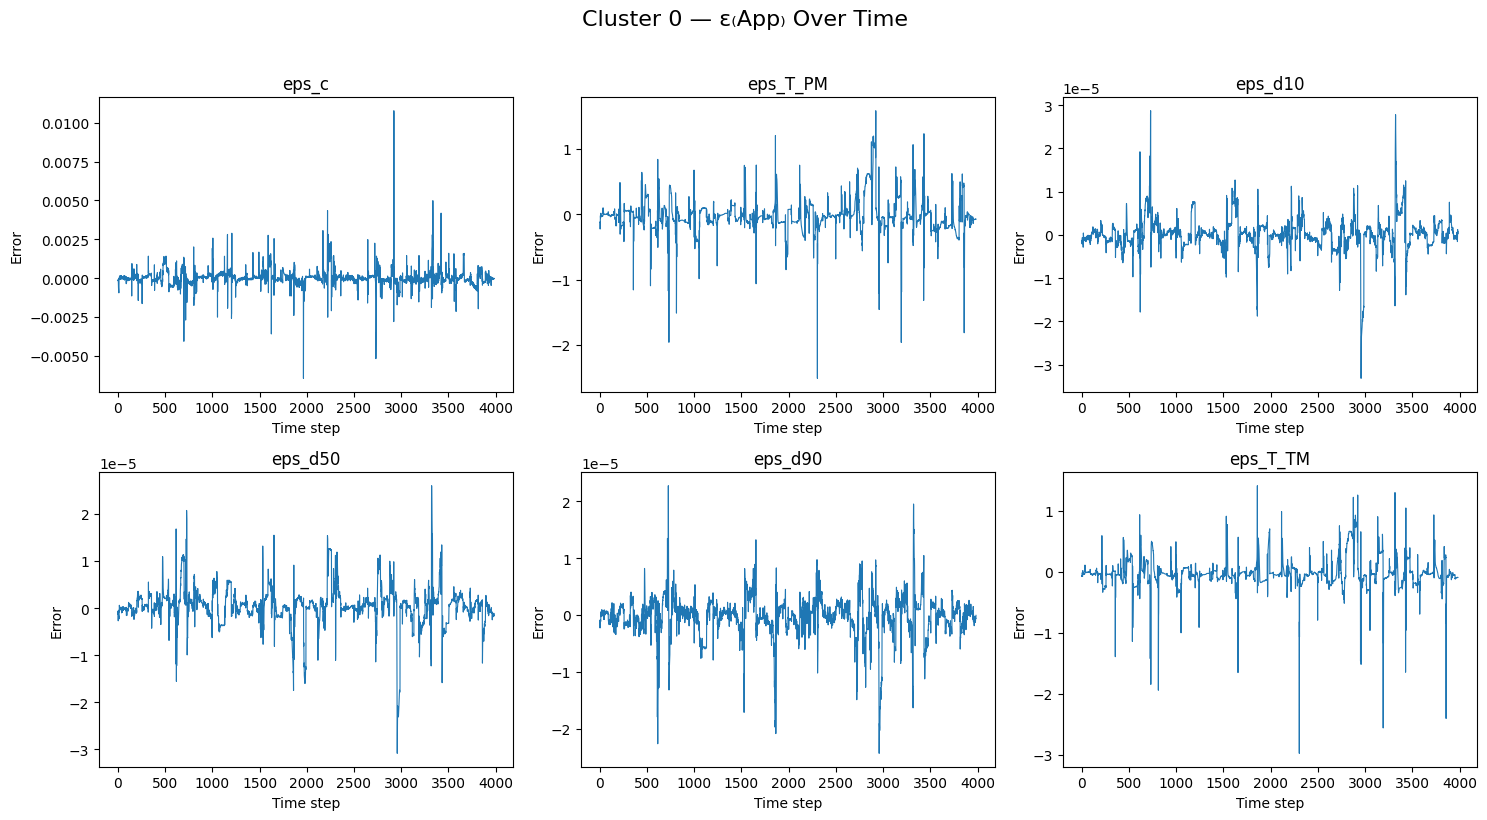

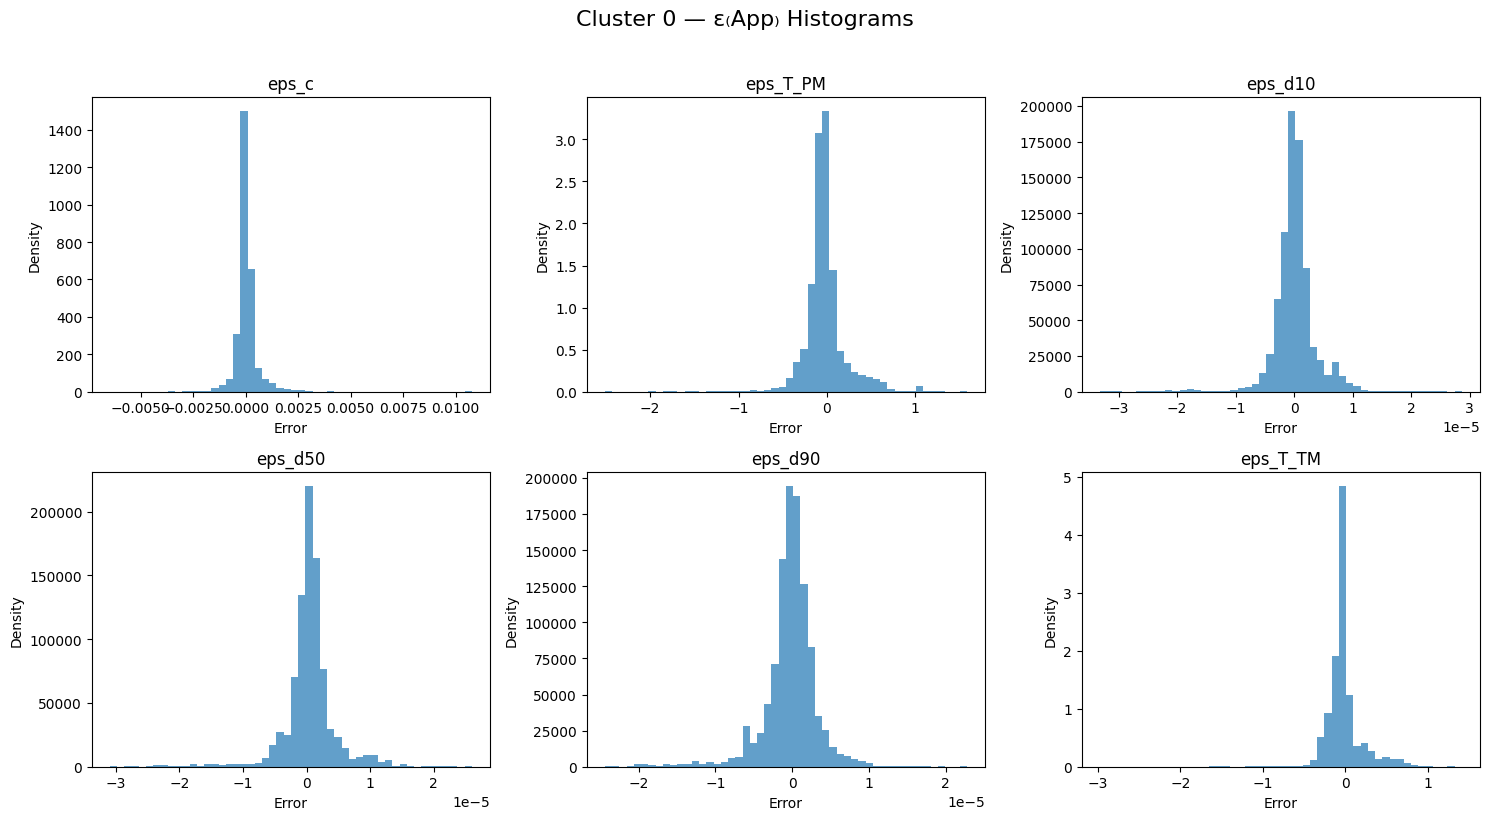

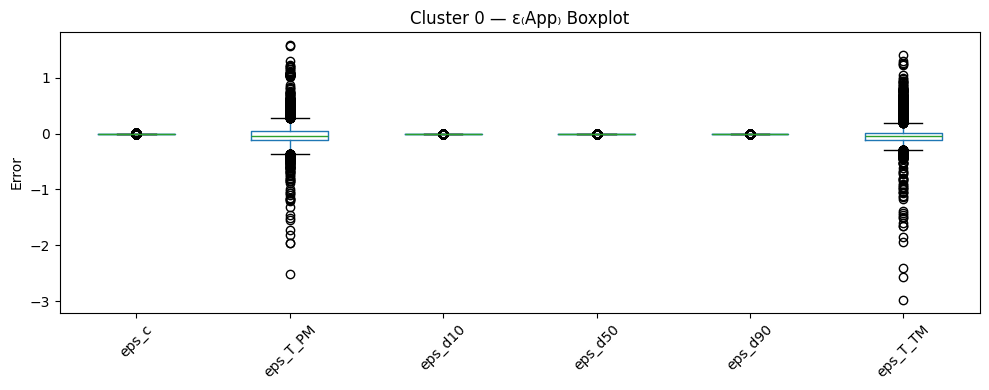


>>> Visualizing ε_app for cluster 1


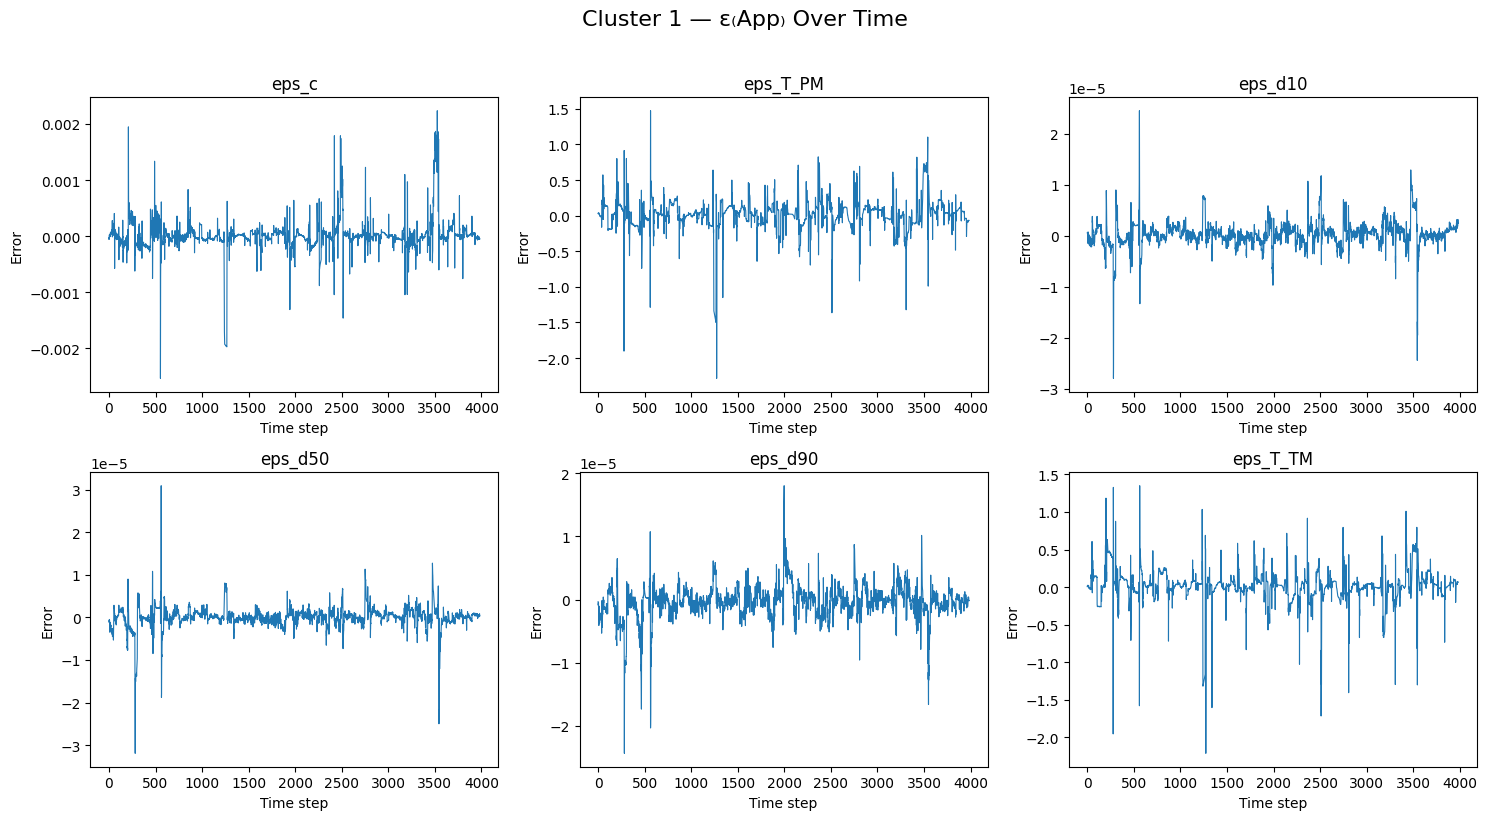

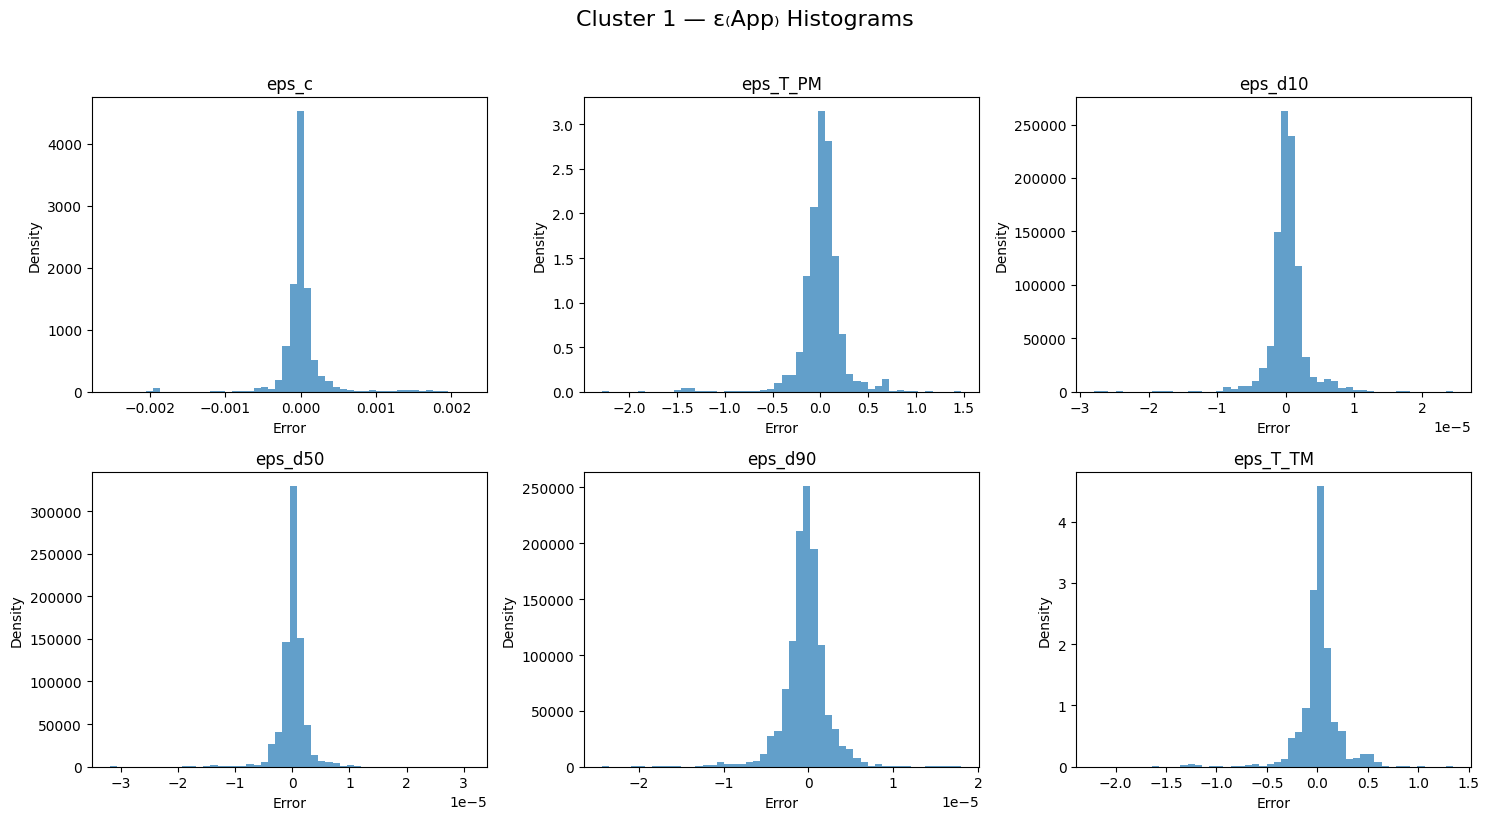

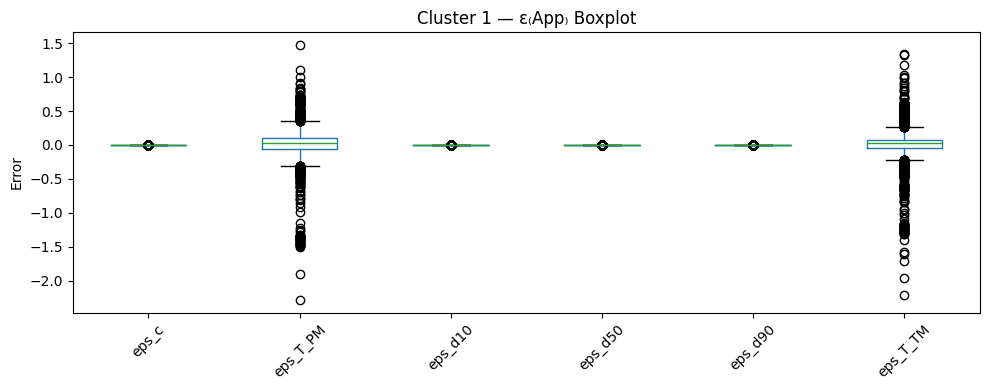

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import re

eps_files = sorted(glob.glob(os.path.join(DATA_DIR_OUT, "eps_app_cluster_*.csv")))
eps_files = [f for f in eps_files if re.match(r".*eps_app_cluster_\d+\.csv", f)]

for eps_csv in eps_files:
    cid = os.path.basename(eps_csv).split("_")[3].split(".")[0]
    df_eps  = pd.read_csv(eps_csv)

    print(f"\n>>> Visualizing ε_app for cluster {cid}")

    states = df_eps.columns.tolist()

    # 1) Plot approximation errors over time
    fig, axes = plt.subplots(2, 3, figsize=(15, 8), tight_layout=True)
    fig.suptitle(f"Cluster {cid} — ε₍App₎ Over Time", y=1.02, fontsize=16)
    time_steps = np.arange(len(df_eps))
    for ax, state in zip(axes.flatten(), states):
        ax.plot(time_steps, df_eps[state], lw=0.8)
        ax.set_title(state)
        ax.set_xlabel("Time step")
        ax.set_ylabel("Error")
    plt.show()

    # 2) Plot histograms
    fig, axes = plt.subplots(2, 3, figsize=(15, 8), tight_layout=True)
    fig.suptitle(f"Cluster {cid} — ε₍App₎ Histograms", y=1.02, fontsize=16)
    for ax, state in zip(axes.flatten(), states):
        ax.hist(df_eps[state], bins=50, density=True, alpha=0.7)
        ax.set_title(state)
        ax.set_xlabel("Error")
        ax.set_ylabel("Density")
    plt.show()

    # 3) Plot a single boxplot of all states
    plt.figure(figsize=(10, 4))
    df_eps.boxplot(grid=False)
    plt.title(f"Cluster {cid} — ε₍App₎ Boxplot")
    plt.ylabel("Error")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



>>> Applying rolling median filter to ε_app for cluster 0


C:\Users\send2\AppData\Local\Temp\ipykernel_828\3033232352.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filtered[col] = df_filtered[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')


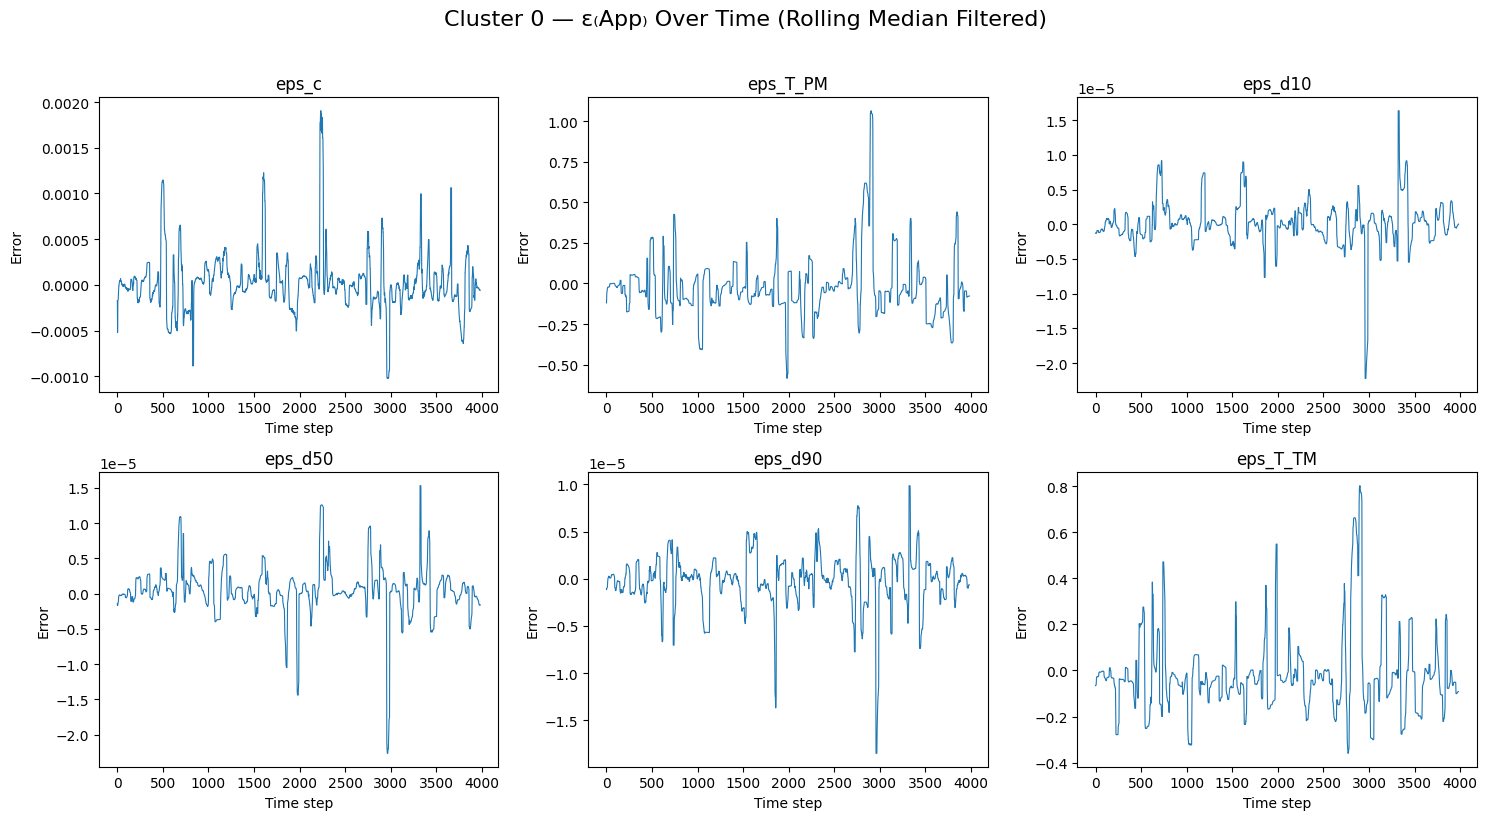

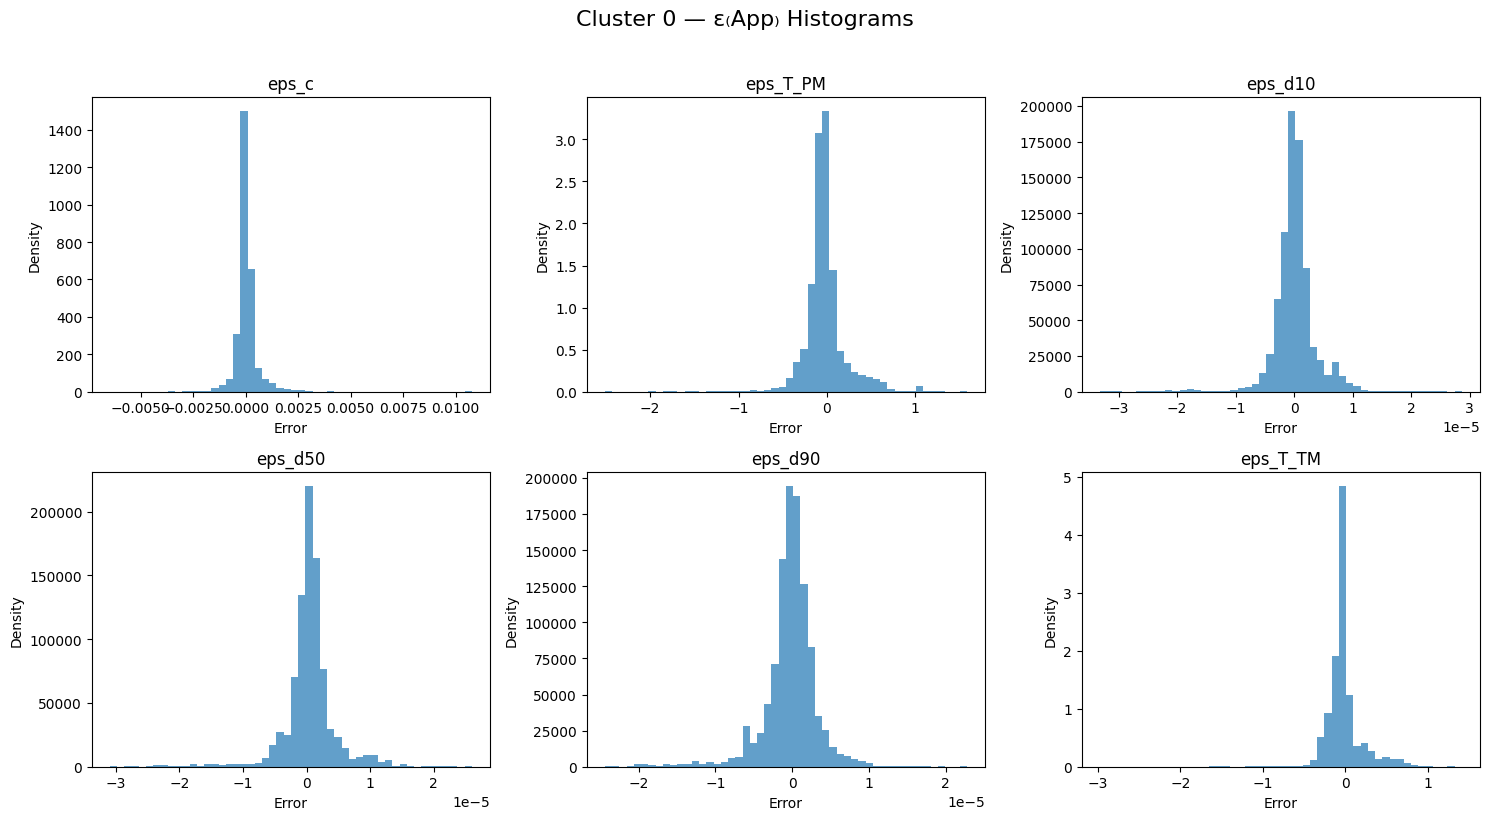

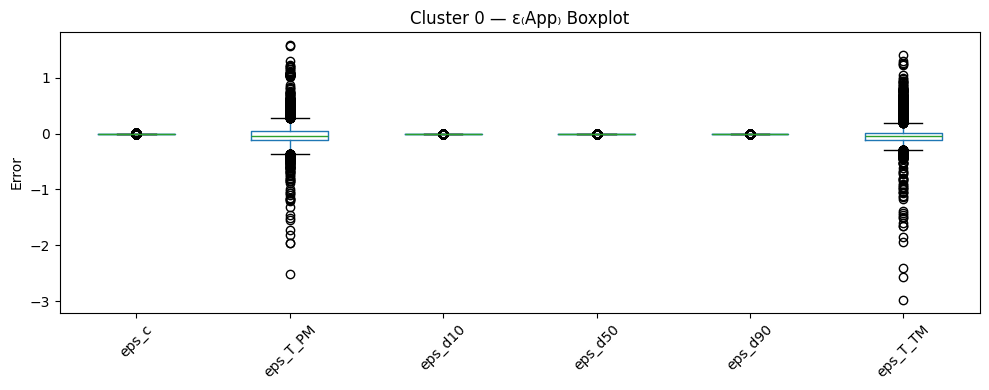


>>> Applying rolling median filter to ε_app for cluster 1


C:\Users\send2\AppData\Local\Temp\ipykernel_828\3033232352.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filtered[col] = df_filtered[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')


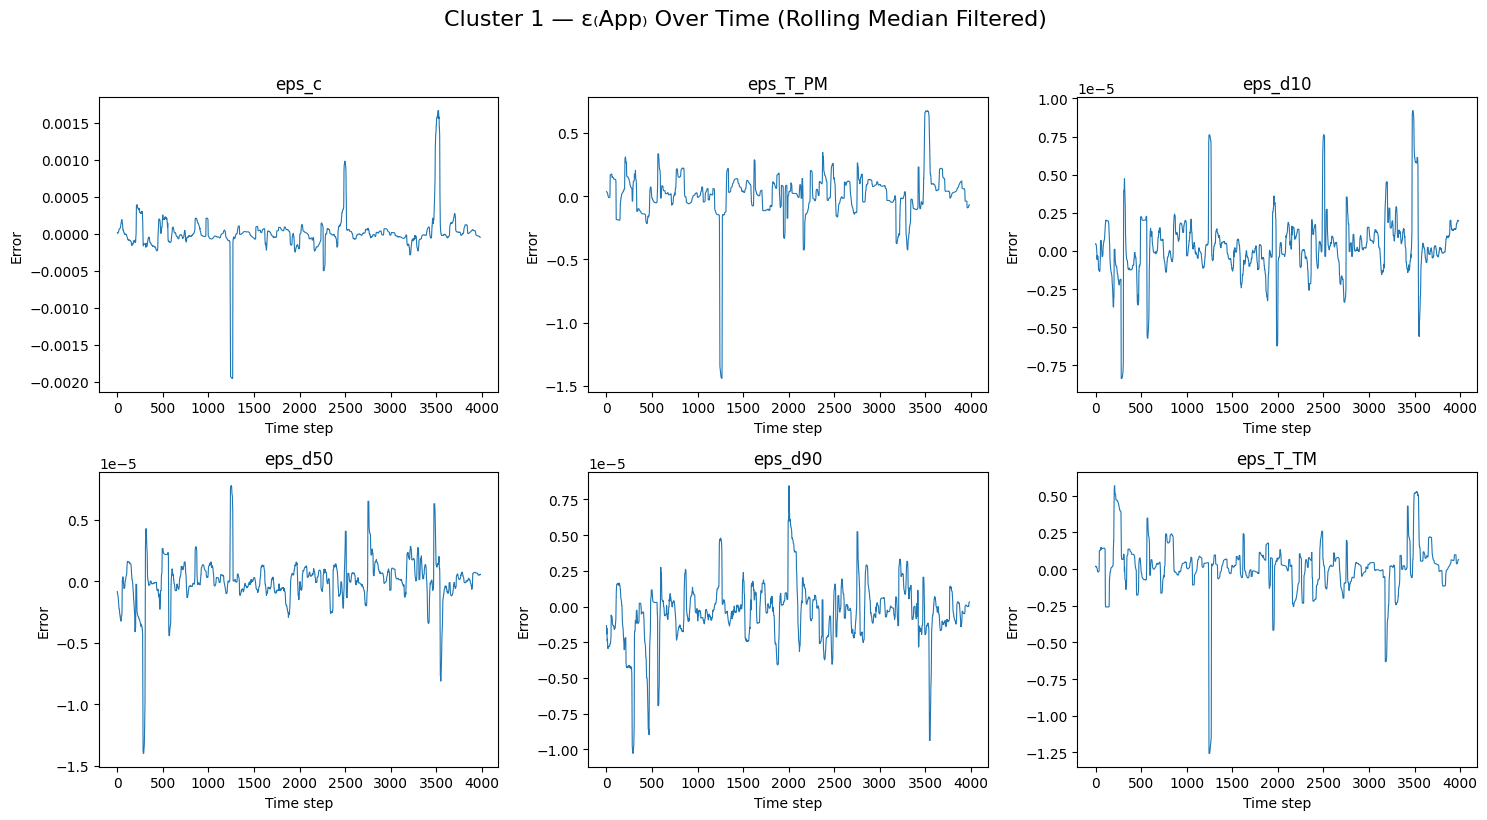

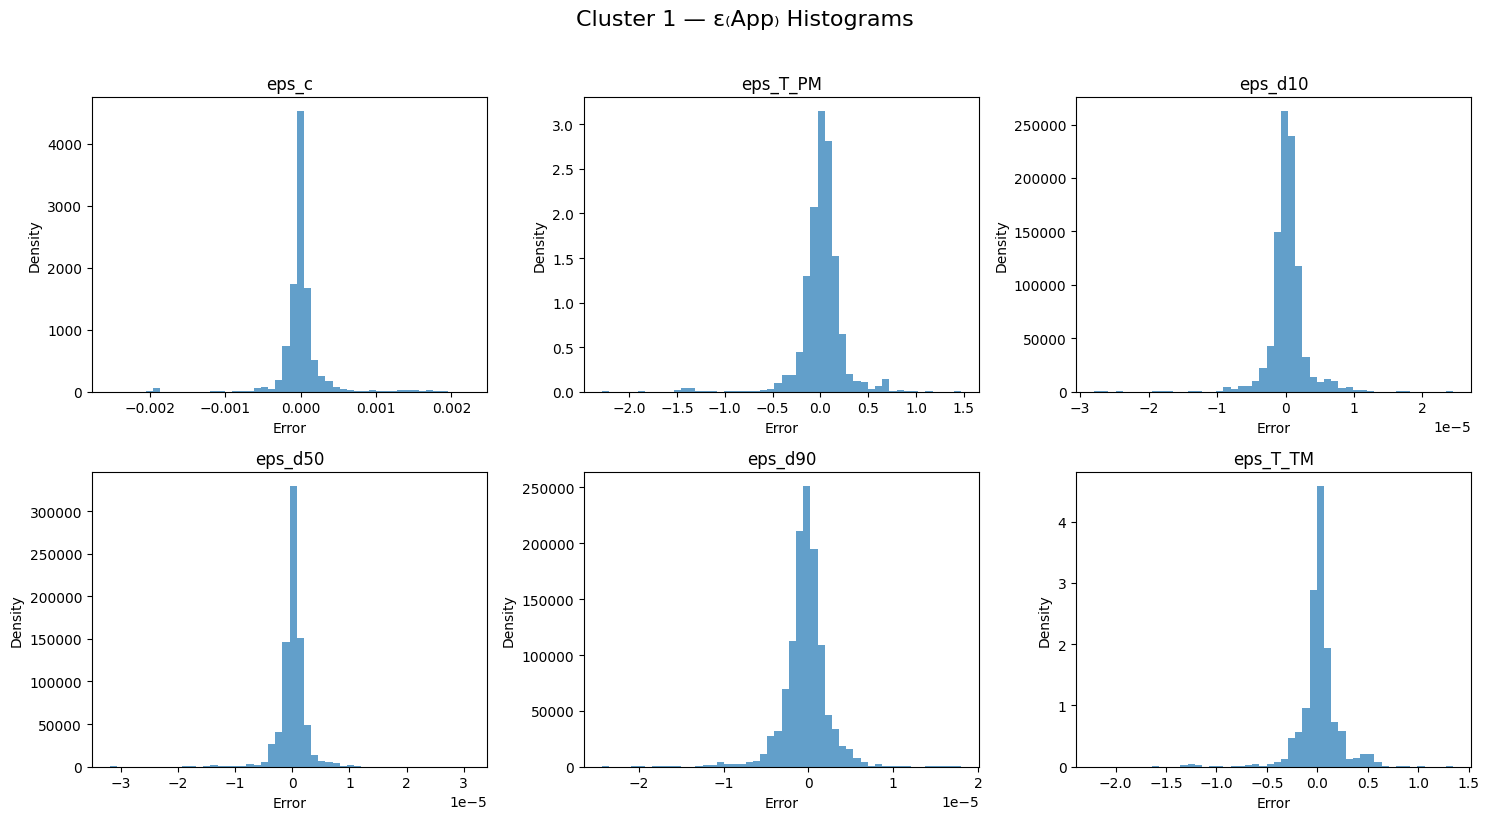

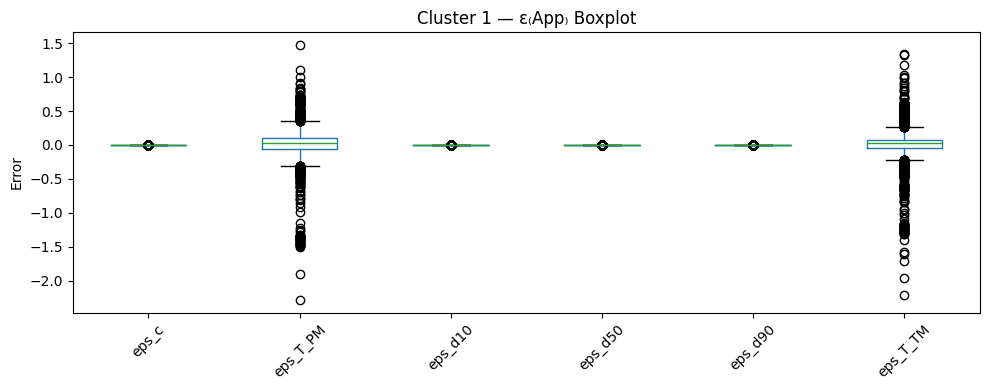

In [23]:
def rolling_median_filter(df, window=5):
    df_filtered = df.copy()
    for col in df_filtered.columns:
        df_filtered[col] = df_filtered[col].rolling(window=window, center=True, min_periods=1).median()
        # Optional: interpolate to fill NaNs at edges after rolling
        df_filtered[col] = df_filtered[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
    return df_filtered

# Usage example inside your visualization loop:
for eps_csv in eps_files:
    cid = os.path.basename(eps_csv).split("_")[3].split(".")[0]
    df_eps = pd.read_csv(eps_csv)

    print(f"\n>>> Applying rolling median filter to ε_app for cluster {cid}")

    df_eps_filtered = rolling_median_filter(df_eps, window=20)  

    # Plot filtered errors over time
    states = df_eps_filtered.columns.tolist()
    fig, axes = plt.subplots(2, 3, figsize=(15, 8), tight_layout=True)
    fig.suptitle(f"Cluster {cid} — ε₍App₎ Over Time (Rolling Median Filtered)", y=1.02, fontsize=16)
    time_steps = np.arange(len(df_eps_filtered))
    for ax, state in zip(axes.flatten(), states):
        ax.plot(time_steps, df_eps_filtered[state], lw=0.8)
        ax.set_title(state)
        ax.set_xlabel("Time step")
        ax.set_ylabel("Error")
    plt.show()
    # 2) Plot histograms
    fig, axes = plt.subplots(2, 3, figsize=(15, 8), tight_layout=True)
    fig.suptitle(f"Cluster {cid} — ε₍App₎ Histograms", y=1.02, fontsize=16)
    for ax, state in zip(axes.flatten(), states):
        ax.hist(df_eps[state], bins=50, density=True, alpha=0.7)
        ax.set_title(state)
        ax.set_xlabel("Error")
        ax.set_ylabel("Density")
    plt.show()
    # 3) Plot a single boxplot of all states
    plt.figure(figsize=(10, 4))
    df_eps.boxplot(grid=False)
    plt.title(f"Cluster {cid} — ε₍App₎ Boxplot")
    plt.ylabel("Error")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# ═════════════════════════════════════════════════════════════


In [24]:
# ═══════════════════════════════════════════════
# 15. Train Quantile Regression Models for ε_app
# ═══════════════════════════════════════════════

import re
import os
import glob
import warnings
import random
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# ── SETTINGS ────────────────────────────────────────────────────────────────────
DROPOUT      = 0.23555278841790406
EPOCHS       = 150
DEVICE       = "cuda" if torch.cuda.is_available() else "cpu"
LR           = 0.0008168455894760162
BATCH_SIZE   = 128

def rolling_median_filter(df: pd.DataFrame | np.ndarray, window=10) -> np.ndarray:
    """
    Apply rolling median filter along the time axis (rows).
    Accepts DataFrame or 2D numpy array, returns numpy array.
    """
    if isinstance(df, np.ndarray):
        df = pd.DataFrame(df)
    df_filtered = df.rolling(window=window, center=True, min_periods=1).median()
    df_filtered = df_filtered.interpolate(method='linear', limit_direction='both')
    return df_filtered.values

# discover clusters dynamically
eps_files = sorted(glob.glob(os.path.join(DATA_DIR_OUT, "eps_app_cluster_*.csv")))
eps_files = [f for f in eps_files if re.match(r".*eps_app_cluster_\d+\.csv", f)]
cluster_ids = [os.path.basename(f).split("_")[3].split(".")[0] for f in eps_files]

# ── Pinball (quantile) loss ───────────────────────────────────────────────────
class PinballLoss(nn.Module):
    def __init__(self, tau: float):
        super().__init__()
        self.tau = tau
    def forward(self, y_pred, y_true):
        diff = y_true - y_pred
        loss = torch.max(self.tau * diff, (self.tau - 1) * diff)
        return loss.mean()

# ── Simple 3-layer quantile net ───────────────────────────────────────────────
class QuantileNet(nn.Module):
    # ── SETTINGS ────────────────────────────────────────────────────────────────
    H1, H2, H3  =  256,64,32# hidden layer sizes
    DROPOUT      = 0.23555278841790406
    EPOCHS       = 150
    DEVICE       = "cuda" if torch.cuda.is_available() else "cpu"
    LR           = 0.0008168455894760162
    BATCH_SIZE   = 128
    def __init__(self, d_in, d_out, H1=H1, H2=H2,H3=H3,dropout=0.05):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, H1), nn.Tanh(), nn.Dropout(dropout),
            nn.Linear(H1, H2), nn.Tanh(), nn.Dropout(dropout),
            nn.Linear(H2, H3), nn.Tanh(),
            nn.Linear(H3, d_out)
        )
    def forward(self, x): return self.net(x)


print(f"[INFO] Found clusters: {cluster_ids}")

for cluster_id in cluster_ids:
    print(f"\n=== Cluster {cluster_id} ===")

    # 1) load calibration features
    calib_csv = os.path.join(DATA_DIR_OUT, f"cluster_{cluster_id}_calib.csv")
    if not os.path.isfile(calib_csv):
        print(f"[WARN] Calibration file missing for cluster {cluster_id} → skipping")
        continue

    files = pd.read_csv(calib_csv, header=None)[0].dropna().astype(str)

    X_list, eps_list = [], []
    # load eps_app
    eps_path = os.path.join(DATA_DIR_OUT, f"eps_app_cluster_{cluster_id}.csv")
    eps_df = pd.read_csv(eps_path)

    # rebuild X_cal then match lengths
    for fn in files:
        # Ensure the file path is correct (use DATA_DIR_IN)
        file_path = os.path.join(DATA_DIR_IN, fn)
        if not os.path.isfile(file_path):
            print(f"[WARN] File missing: {file_path} → skipping")
            continue
        df = read_txt(file_path)
        Xf, _ = build_narx(df)
        X_list.append(Xf)

    if not X_list:
        print(f"[WARN] No valid calibration data for cluster {cluster_id} → skipping")
        continue
    X_cal = np.vstack(X_list)

    # Apply rolling median filter to smooth errors before training quantile nets
    eps_cal_raw = eps_df.values[:len(X_cal), :]  # align rows
    eps_cal = rolling_median_filter(eps_cal_raw, window=5)

    # 2) scale X only
    xscaler = StandardScaler().fit(X_cal)
    Xs = xscaler.transform(X_cal)
    Ys = eps_cal.astype(np.float32)

    ds = TensorDataset(torch.from_numpy(Xs), torch.from_numpy(Ys))
    loader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True)

    d_in  = Xs.shape[1]
    print(d_in, "input features")
    d_out = Ys.shape[1]
    print(d_out, "output states (ε_app)")

    for tau in (0.05, 0.95):
        print(f" training τ={tau:.2f} quantile")
        net   = QuantileNet(d_in, d_out).to(DEVICE)
        loss_fn = PinballLoss(tau).to(DEVICE)
        opt   = torch.optim.Adam(net.parameters(), lr=LR)

        # train
        for epoch in range(1, EPOCHS+1):
            net.train()
            total = 0.0
            for xb, yb in loader:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                opt.zero_grad()
                yp = net(xb)
                loss = loss_fn(yp, yb)
                loss.backward()
                opt.step()
                total += loss.item() * xb.size(0)
            if epoch % 20 == 0:
                print(f"  epoch {epoch}/{EPOCHS}  loss={total/len(ds):.4e}")

        # save model + scaler + τ
        out_path = os.path.join(DATA_DIR_OUT, f"quantile_{tau:.2f}_cluster_{cluster_id}.pt")
        torch.save({
            "model": net.cpu().state_dict(),
            "x_mean": xscaler.mean_, "x_scale": xscaler.scale_,
            "tau": tau,
            "config": dict(NA=NA, NB=NB, H1=H1, H2=H2, H3=H3)
        }, out_path)
        print(f"  ✓ saved {os.path.basename(out_path)}")


[INFO] Found clusters: ['0', '1']

=== Cluster 0 ===
27 input features
6 output states (ε_app)
 training τ=0.05 quantile
  epoch 20/150  loss=4.8933e-03
  epoch 40/150  loss=4.3922e-03
  epoch 60/150  loss=4.0133e-03
  epoch 80/150  loss=3.8115e-03
  epoch 100/150  loss=3.7050e-03
  epoch 120/150  loss=3.5698e-03
  epoch 140/150  loss=3.3952e-03
  ✓ saved quantile_0.05_cluster_0.pt
 training τ=0.95 quantile
  epoch 20/150  loss=5.3378e-03
  epoch 40/150  loss=4.9076e-03
  epoch 60/150  loss=4.7751e-03
  epoch 80/150  loss=4.6016e-03
  epoch 100/150  loss=4.2930e-03
  epoch 120/150  loss=4.1764e-03
  epoch 140/150  loss=3.8657e-03
  ✓ saved quantile_0.95_cluster_0.pt

=== Cluster 1 ===
27 input features
6 output states (ε_app)
 training τ=0.05 quantile
  epoch 20/150  loss=6.1606e-03
  epoch 40/150  loss=5.5735e-03
  epoch 60/150  loss=5.1029e-03
  epoch 80/150  loss=4.8143e-03
  epoch 100/150  loss=4.5701e-03
  epoch 120/150  loss=4.2983e-03
  epoch 140/150  loss=4.1816e-03
  ✓ saved q

[INFO] Found clusters: ['0', '1']

>>> Cluster 0
 α per state: {'c': np.float64(0.0010684303930530669), 'T_PM': np.float64(-0.009100533055175759), 'd10': np.float64(-0.0019524922477744647), 'd50': np.float64(-0.0012332873709953623), 'd90': np.float64(-0.0006566351396064416), 'T_TM': np.float64(-0.007360626663394904)}
[✓] Wrote conformal intervals → cqr_intervals_cluster_0.csv


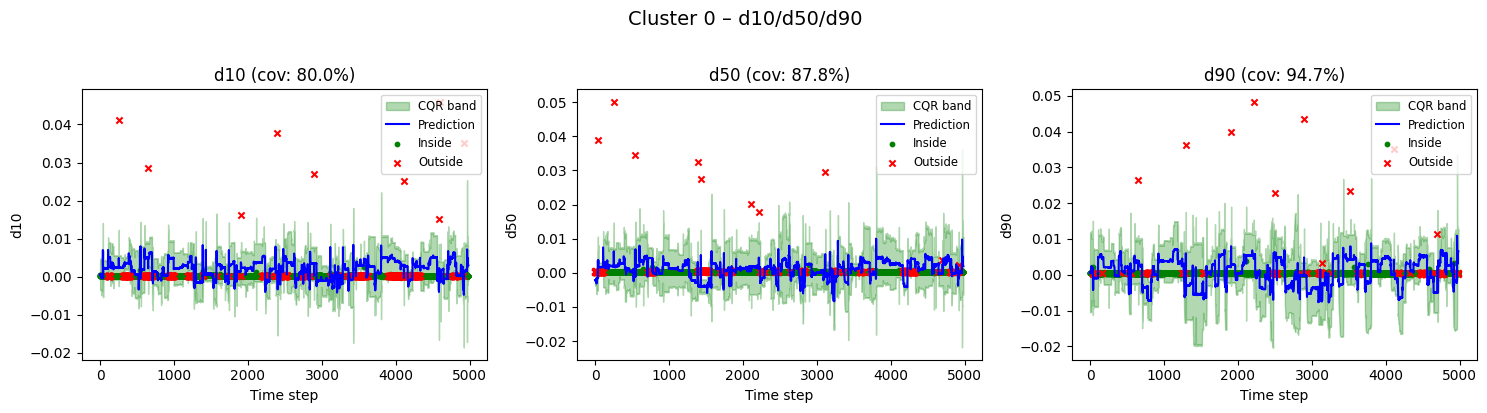


>>> Cluster 1
 α per state: {'c': np.float64(0.0007211796940927527), 'T_PM': np.float64(-0.009900270824306457), 'd10': np.float64(0.0008617869054506096), 'd50': np.float64(-0.0006151153385742045), 'd90': np.float64(-0.00042005141739876156), 'T_TM': np.float64(-0.0029369596622295393)}
[✓] Wrote conformal intervals → cqr_intervals_cluster_1.csv


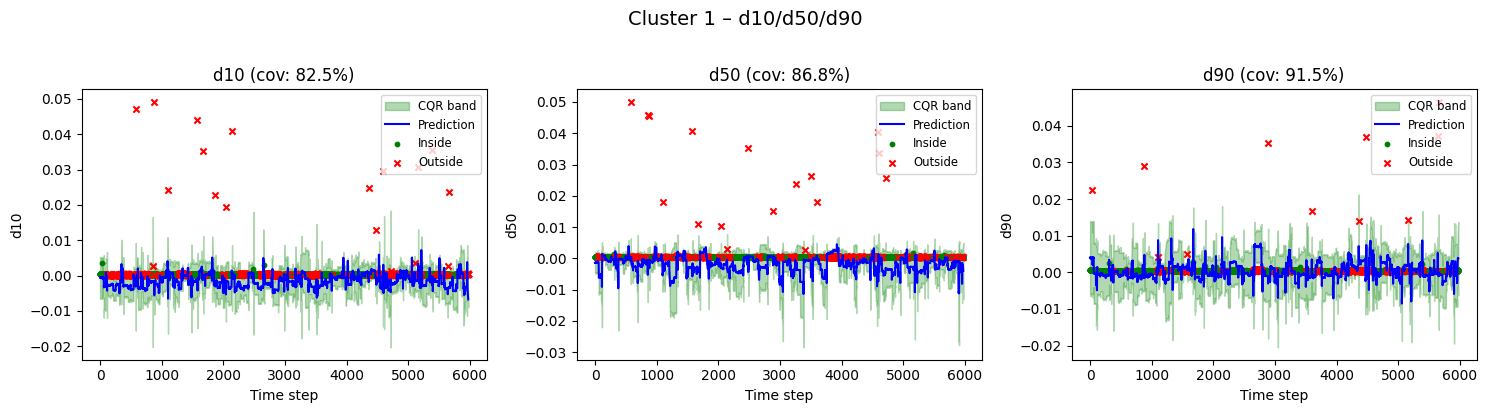

In [25]:
# ═══════════════════════════════════════════════
# 16. CONFORMALIZED QUANTILE REGRESSION
# ═══════════════════════════════════════════════

import re

ALPHA_LEVEL = 0.10  # 90% coverage

# discover clusters dynamically
eps_files = sorted(glob.glob(os.path.join(DATA_DIR_OUT, "eps_app_cluster_*.csv")))
eps_files = [f for f in eps_files if re.match(r".*eps_app_cluster_\d+\.csv", f)]
cluster_ids = [os.path.basename(f).split("_")[3].split(".")[0] for f in eps_files]

print(f"[INFO] Found clusters: {cluster_ids}")

for cluster_id in cluster_ids:
    print(f"\n>>> Cluster {cluster_id}")

    # 1) Load τ=0.05 & τ=0.95 quantile nets + their X‐scaler
    q_models = {}
    for tau in (0.05, 0.95):
        ckpt = torch.load(
            os.path.join(DATA_DIR_OUT, f"quantile_{tau:.2f}_cluster_{cluster_id}.pt"),
            map_location=DEVICE,
            weights_only=False
        )
        xsc = StandardScaler()
        xsc.mean_, xsc.scale_ = ckpt["x_mean"], ckpt["x_scale"]
        net = QuantileNet(len(xsc.mean_), len(TARGET_COLS)).to(DEVICE)
        net.load_state_dict(ckpt["model"])
        net.eval()
        q_models[tau] = (net, xsc)
# 2) Build calibration features & true errors ε_app
    calib_csv = os.path.join(DATA_DIR_OUT, f"cluster_{cluster_id}_calib.csv")
    calib_files = pd.read_csv(calib_csv, header=None)[0].dropna().astype(str)

    X_list = []
    for fn in calib_files:
        df = read_txt(os.path.join(DATA_DIR_IN, fn))
        Xf, _ = build_narx(df)
        X_list.append(Xf)
    X_cal = np.vstack(X_list)

    eps_cal = pd.read_csv(
        os.path.join(DATA_DIR_OUT, f"eps_app_cluster_{cluster_id}.csv")
    ).values[: len(X_cal), :]

    # 3) Compute predicted lower/upper quantiles on calibration
    nets = {}
    for tau, (net, xsc) in q_models.items():
        Xs = xsc.transform(X_cal)
        with torch.no_grad():
            q = net(torch.from_numpy(Xs).to(DEVICE)).cpu().numpy()
        nets[tau] = q

    q_lo_cal = nets[0.05]
    q_hi_cal = nets[0.95]

    # 4) Compute conformity scores s_i
    s = np.maximum(q_lo_cal - eps_cal, eps_cal - q_hi_cal)
    alpha = np.quantile(s, 1 - ALPHA_LEVEL, axis=0)
    print(" α per state:", dict(zip(TARGET_COLS, alpha)))

    # 5) Test set: build features
    test_csv = os.path.join(DATA_DIR_OUT, f"cluster_{cluster_id}_test.csv")
    test_files = pd.read_csv(test_csv, header=None)[0].dropna().astype(str)
    X_list, Y_list = [], []
    for fn in test_files:
        df = read_txt(os.path.join(DATA_DIR_IN, fn))
        Xf, Yf = build_narx(df)
        X_list.append(Xf)
        Y_list.append(Yf)
    X_test = np.vstack(X_list)
    Y_test = np.vstack(Y_list)

    Xs = q_models[0.05][1].transform(X_test)

    # 6) Predict quantiles on test
    with torch.no_grad():
        q_lo_test = q_models[0.05][0](torch.from_numpy(Xs).to(DEVICE)).cpu().numpy()
        q_hi_test = q_models[0.95][0](torch.from_numpy(Xs).to(DEVICE)).cpu().numpy()

    # 7) Expand intervals with α
    lower_int = q_lo_test - alpha
    upper_int = q_hi_test + alpha

    # 8) Save intervals
    df_int = pd.DataFrame(
        np.hstack([lower_int, upper_int]),
        columns=[f"{s}_lo" for s in TARGET_COLS] +
                [f"{s}_hi" for s in TARGET_COLS]
    )
    df_int.to_csv(
        os.path.join(DATA_DIR_OUT, f"cqr_intervals_cluster_{cluster_id}.csv"),
        index=False
    )
    print(f"[✓] Wrote conformal intervals → cqr_intervals_cluster_{cluster_id}.csv")

    # 9) Visualize coverage for d10/d50/d90
    if Y_test is None or lower_int is None:
        raise ValueError("Y_test or lower_int is None. Cannot compute length.")
    n = min(len(Y_test), len(lower_int))
    time = np.arange(n)
    preds = (q_lo_test[:n] + q_hi_test[:n]) / 2  # center of predicted band
    Y_test = Y_test[:n]
    lower_int = lower_int[:n]
    upper_int = upper_int[:n]

    states_to_plot = ["d10", "d50", "d90", "T_PM", "T_TM", "c"]
    fig, axes = plt.subplots(1, 3, figsize=(15, 4), tight_layout=True)
    fig.suptitle(f"Cluster {cluster_id} – d10/d50/d90", fontsize=14, y=1.02)

    for ax, state in zip(axes, states_to_plot):
        i = TARGET_COLS.index(state)
        y_true = Y_test[:, i]
        y_pred = preds[:, i]
        lo = lower_int[:, i]
        hi = upper_int[:, i]

        inside = (y_true >= lo) & (y_true <= hi)
        outside = ~inside
        cov = inside.mean() * 100

        ax.fill_between(time, lo, hi, color="green", alpha=0.3, label="CQR band")
        ax.plot(time, y_pred, color="blue", lw=1.5, label="Prediction")
        ax.scatter(time[inside], y_true[inside], c="green", s=10, label="Inside")
        ax.scatter(time[outside], y_true[outside], c="red", s=20, marker="x", label="Outside")

        ax.set_title(f"{state} (cov: {cov:.1f}%)")
        ax.set_xlabel("Time step")
        ax.set_ylabel(state)
        ax.legend(loc="upper right", fontsize="small")

    plt.show()